In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import folium
from sklearn import preprocessing
import geopandas as gpd
import matplotlib.colors as colors
import matplotlib.colors as colors
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from helpers import *
from ipywidgets import SelectMultiple, RadioButtons, interact, Layout
%load_ext autoreload
%autoreload 2

### Dataset raw files names

In [2]:
# Crops and livestock
CROPS = 'Production_Crops.csv'
LIVE_STOCK = 'Production_Livestock.csv'
VALUE_PROD = 'Value_of_Production.csv'
TRADE = 'Trade_Crops_Livestock.csv'
TRADE_MATRIX = 'Trade_Matrix.csv'

In [3]:
# Fertilizers, pesticides, emissions
EMISSIONS = 'Emissions_Agriculture.csv'
FERT_A = 'Fertilizers_Archive.csv'
FERT_N = 'Fertilizers_Nutrient.csv'
FERT_P = 'Fertilizers_Product.csv'
FERT_I = 'Fertilizers_Indicators.csv'
PESTICIDES = 'Pesticides.csv'

In [4]:
# Environment
LAND = 'Land_Use.csv'
WATER = 'Water.csv'
SOIL = 'Soil.csv'
CLIMATE = 'Environment_Temperature.csv'
ENERGY = 'Energy.csv'

In [5]:
# World countries names from geopandas
world_df = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
countries = set(world_df['name'])

## Crops Production

We start our analysis from the agriculture and livestock datasets.

In [6]:
# Loading the DataSet
crops = pd.read_csv('datasets/'+CROPS, encoding = "ISO-8859-1")

In [7]:
# See how the data is organized
crops.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Y1961,Y1962,Y1963,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
0,2,Afghanistan,221,"Almonds, with shell",5312,Area harvested,ha,NaN,NaN,NaN,...,12000.0,11029.0,11210.0,13469.0,13490.0,14114.0,13703.0,14676.0,19481.0,19793.0
1,2,Afghanistan,221,"Almonds, with shell",5419,Yield,hg/ha,NaN,NaN,NaN,...,35000.0,39154.0,49955.0,45000.0,45960.0,29910.0,19996.0,16521.0,16859.0,13788.0
2,2,Afghanistan,221,"Almonds, with shell",5510,Production,tonnes,NaN,NaN,NaN,...,42000.0,43183.0,56000.0,60611.0,62000.0,42215.0,27400.0,24246.0,32843.0,27291.0
3,2,Afghanistan,711,"Anise, badian, fennel, coriander",5312,Area harvested,ha,NaN,NaN,NaN,...,15000.0,17748.0,17000.0,19500.0,18500.0,18500.0,30000.0,25000.0,26019.0,28873.0
4,2,Afghanistan,711,"Anise, badian, fennel, coriander",5419,Yield,hg/ha,NaN,NaN,NaN,...,6000.0,6203.0,6000.0,6414.0,6757.0,6757.0,7167.0,7200.0,6923.0,6830.0


We now create a function to get all the unique values from the columns `Item`, `Element` and `Unit` in order to better understand what data is contained in the dataset.

In [8]:
def uniquevalues(df):
    for i in ['Item', 'Element', 'Unit', 'Area']:
        print(i)
        print(df[i].unique())

In [9]:
uniquevalues(crops)

Item
['Almonds, with shell' 'Anise, badian, fennel, coriander' 'Apples'
 'Apricots' 'Barley' 'Berries nes' 'Cotton lint' 'Cottonseed' 'Figs'
 'Fruit, citrus nes' 'Fruit, fresh nes' 'Fruit, stone nes' 'Grapes'
 'Linseed' 'Maize' 'Melons, other (inc.cantaloupes)' 'Millet' 'Nuts, nes'
 'Olives' 'Onions, dry' 'Oranges' 'Peaches and nectarines' 'Pears'
 'Pistachios' 'Plums and sloes' 'Potatoes' 'Pulses, nes' 'Rice, paddy'
 'Seed cotton' 'Sesame seed' 'Spices, nes' 'Sugar beet' 'Sugar cane'
 'Sunflower seed' 'Vegetables, fresh nes' 'Walnuts, with shell'
 'Watermelons' 'Wheat' 'Cereals (Rice Milled Eqv)' 'Cereals,Total'
 'Citrus Fruit,Total' 'Coarse Grain, Total' 'Fibre Crops Primary'
 'Fruit Primary' 'Oilcrops, Cake Equivalent' 'Oilcrops, Oil Equivalent'
 'Pulses,Total' 'Roots and Tubers,Total' 'Treenuts,Total'
 'Vegetables Primary' 'Beans, dry' 'Beans, green'
 'Broad beans, horse beans, dry' 'Cabbages and other brassicas'
 'Carrots and turnips' 'Cauliflowers and broccoli' 'Cherries'
 'Cherr

As we can see, in the `Item` column, the kind of vegetable or fruit considered is reported, as well as total values for some categories. In the `Element` columns we have instead either the harvested area, the amount produced or the yield which is the harvested production per unit of harvested area for all the crop products.

For each `Element` there is a different unit parameter (as stated in the FAO website): 
- Production : tonnes
- Area harvested: hectares
- Yield: tonnes per hectare.

We decided to keep and separate data for Production and for Yield, because this features are more significant for the purpose of the project in general.

In [10]:
# Save data in a new DataFrame and see the result
crops_production = crops[crops['Element']=='Production']
crops_production.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Y1961,Y1962,Y1963,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
2,2,Afghanistan,221,"Almonds, with shell",5510,Production,tonnes,NaN,NaN,NaN,...,42000.0,43183.0,56000.0,60611.0,62000.0,42215.0,27400.0,24246.0,32843.0,27291.0
5,2,Afghanistan,711,"Anise, badian, fennel, coriander",5510,Production,tonnes,NaN,NaN,NaN,...,9000.0,11008.0,10200.0,12508.0,12500.0,12500.0,21500.0,18000.0,18012.0,19719.0
8,2,Afghanistan,515,Apples,5510,Production,tonnes,15100.0,15100.0,15100.0,...,56061.0,72765.0,59850.0,62041.0,70000.0,78597.0,89403.0,89733.0,140903.0,175000.0
11,2,Afghanistan,526,Apricots,5510,Production,tonnes,32000.0,32000.0,32000.0,...,59559.0,60000.0,66560.0,67995.0,83500.0,90000.0,90000.0,87686.0,17894.0,131816.0
14,2,Afghanistan,44,Barley,5510,Production,tonnes,378000.0,378000.0,378000.0,...,333000.0,486000.0,437000.0,305900.0,504000.0,514000.0,521000.0,403000.0,301856.0,94995.0


In [11]:
# Check that we have a unique unit now
crops_production.Unit.unique()

array(['tonnes'], dtype=object)

Considering the `Area` column, we can see that there are rows that actually represent a region and not a specific Country. We want to drop these columns. There are also some countries that have changed over time such as Sudan that is classified as Sudan and Sudan(former). We want to collect the data and refer it to a unique country.

Since the ultimate goal is to obtain a colormap of the world, we use the GeoPandas package. We then change the names of all the countries that have different names from the ones used by GeoPandas (e.g. 'Bosnia and Herzegovina' is replaced by 'Bosnia and Herz.').

In [12]:
changes = {'Area' : { 'Bosnia and Herzegovina' : 'Bosnia and Herz.' ,
                    'Brunei Darussalam' : 'Brunei',
                    'Czechoslovakia' : 'Czechia',
                    'Republic of Korea' : 'South Korea',
                    "Democratic People's Republic of Korea" : 'North Korea',
                    'Democratic Republic of the Congo' : 'Dem. Rep. Congo',
                    'Bolivia (Plurinational State of)' : 'Bolivia',
                    'Venezuela (Bolivarian Republic of)' : 'Venezuela',
                    'Republic of Moldova' : 'Moldova',
                    'Dominican Republic' : 'Dominican Rep.',
                    'Equatorial Guinea' : 'Eq. Guinea',
                    'Eswatini' : 'eSwatini',
                    'Ethiopia PDR' : 'Ethiopia',
                    'Iran (Islamic Republic of)' :'Iran',
                    'Serbia and Montenegro' : 'Serbia',
                    'Sudan (former)' : 'Sudan',
                    'South Sudan' : 'S. Sudan',
                    'Syrian Arab Republic' : 'Syria',
                    'The former Yugoslav Republic of Macedonia' : 'Macedonia',
                    'United Republic of Tanzania' : 'Tanzania',
                    'Viet Nam' : 'Vietnam',
                    'Russian Federation' : 'Russia',
                    'Central African Republic' : 'Central African Rep.',
                    'USSR' : 'Russia'
                    }}

In [13]:
crops_production = crops_production.replace(changes)

Since the dataset already contains in the `Item` column some total values for different categories, we could extract only those values. Moreover, all the production is reported in terms of tonnes, and so we can also report the total production (as a first approximation: we don't know exactly if all products are considered in those categories, or if some product is considered in more than one category).

We consider the following categories (with respective codes):
* 1717: `Cereals`
* 1720: `Roots and tubers`
* 1726: `Pulses`
* 1729: `Treenuts`
* 1732: `Oilcrops`
* 1735: `Vegetables`
* 1738: `Fruit`
* 1753: `Fibre crops`

Therefore we select each category, group by the `Area` and sum the values (if necessary for some reason).

In [14]:
item_code_list = [1717, 1720, 1726, 1729, 1732, 1735, 1738, 1753]
crops_production = crops_production.loc[crops_production['Item Code'].map(lambda x: x in item_code_list),]

In [15]:
# Calculate the total production
crops_production = crops_production.groupby(['Area','Item']).sum()
to_drop = ['Area Code','Item Code','Element Code']
crops_production = crops_production.drop(to_drop, axis=1)

In [16]:
# Check the result
crops_production.head(8)

Y1961      Y1962      Y1963  \
Area        Item                                                        
Afghanistan Cereals,Total             3695000.0  3696000.0  3378000.0   
            Fibre Crops Primary         17000.0    26000.0    36700.0   
            Fruit Primary              567200.0   565000.0   571700.0   
            Oilcrops, Oil Equivalent    24700.0    28366.0    31752.0   
            Pulses,Total                18000.0    18600.0    19600.0   
            Roots and Tubers,Total     130000.0   115000.0   122000.0   
            Treenuts,Total              10500.0    12600.0    10700.0   
            Vegetables Primary         291300.0   306300.0   324600.0   

                                          Y1964      Y1965      Y1966  \
Area        Item                                                        
Afghanistan Cereals,Total             3732000.0  3785000.0  3489000.0   
            Fibre Crops Primary         26000.0    25000.0    20300.0   
            Fruit Primary              663800.0   715200.0   778700.0   
            Oilcrops, Oil Equivalent    28366.0    28796.0    28524.0   
            Pulses,Total                20600.0    21700.0    22600.0   
            Roots and Tubers,Total     129000.0   132000.0   136000.0   
            Treenuts,Total              11200.0    12300.0    13000.0   
            Vegetables Primary         342900.0   357500.0   361200.0   

                                          Y1967      Y1968      Y1969  \
Area        Item                                                        
Afghanistan Cereals,Total             3826000.0  3916000.0  4038000.0   
            Fibre Crops Primary         23100.0    23700.0    28700.0   
            Fruit Primary              913000.0   922000.0   933300.0   
            Oilcrops, Oil Equivalent    29380.0    30199.0    32352.0   
            Pulses,Total                15000.0    24600.0    25600.0   
            Roots and Tubers,Total     147000.0   150000.0   154000.0   
            Treenuts,Total              12000.0    13700.0    13300.0   
            Vegetables Primary         391000.0   401100.0   411400.0   

                                          Y1970  ...      Y2008      Y2009  \
Area        Item                                 ...                         
Afghanistan Cereals,Total             3512000.0  ...  3950000.0  6514000.0   
            Fibre Crops Primary         25300.0  ...    11550.0    14148.0   
            Fruit Primary              893000.0  ...  1244514.0  1459939.0   
            Oilcrops, Oil Equivalent    30146.0  ...    19705.0    20717.0   
            Pulses,Total                26700.0  ...    51000.0    50000.0   
            Roots and Tubers,Total     144000.0  ...   280000.0   302400.0   
            Treenuts,Total              13200.0  ...    55833.0    56365.0   
            Vegetables Primary         383600.0  ...  1009392.0  1022578.0   

                                          Y2010      Y2011      Y2012  \
Area        Item                                                        
Afghanistan Cereals,Total             5957000.0  4681020.0  6379000.0   
            Fibre Crops Primary         10890.0    10890.0    11979.0   
            Fruit Primary             1360109.0  1274114.0  1352528.0   
            Oilcrops, Oil Equivalent    19318.0    19620.0    19965.0   
            Pulses,Total                53300.0    67000.0    69000.0   
            Roots and Tubers,Total     246000.0   205000.0   230000.0   
            Treenuts,Total              71463.0    78312.0    79832.0   
            Vegetables Primary         969763.0   762948.0   817744.0   

                                          Y2013      Y2014      Y2015  \
Area        Item                                                        
Afghanistan Cereals,Total             6520329.0  6748125.0  5809811.0   
            Fibre Crops Primary         13917.0    14000.0        0.0   
            Fruit Primary             1346187

In the FAO's Datasets we have several information related to areas which are not state (e.g. `Europe`). Right now we don't need this information so drop those columns.

In [17]:
crops_production = crops_production.reset_index().set_index('Area')
to_delete = set(crops_production.index).difference(countries)
crops_production = crops_production.drop(to_delete, axis=0)

In [18]:
# Check the result
crops_production.head()

,Item,Y1961,Y1962,Y1963,Y1964,Y1965,Y1966,Y1967,Y1968,Y1969,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
Area,,,,,,,,,,,,,,,,,,,,,
Afghanistan,"Cereals,Total",3695000.0,3696000.0,3378000.0,3732000.0,3785000.0,3489000.0,3826000.0,3916000.0,4038000.0,...,3950000.0,6514000.0,5957000.0,4681020.0,6379000.0,6520329.0,6748125.0,5809811.0,5534902.0,4897143.0
Afghanistan,Fibre Crops Primary,17000.0,26000.0,36700.0,26000.0,25000.0,20300.0,23100.0,23700.0,28700.0,...,11550.0,14148.0,10890.0,10890.0,11979.0,13917.0,14000.0,0.0,0.0,0.0
Afghanistan,Fruit Primary,567200.0,565000.0,571700.0,663800.0,715200.0,778700.0,913000.0,922000.0,933300.0,...,1244514.0,1459939.0,1360109.0,1274114.0,1352528.0,1346187.0,1714567.0,1832632.0,2602757.0,2496509.0
Afghanistan,"Oilcrops, Oil Equivalent",24700.0,28366.0,31752.0,28366.0,28796.0,28524.0,29380.0,30199.0,32352.0,...,19705.0,20717.0,19318.0,19620.0,19965.0,23083.0,23302.0,0.0,0.0,0.0
Afghanistan,"Pulses,Total",18000.0,18600.0,19600.0,20600.0,21700.0,22600.0,15000.0,24600.0,25600.0,...,51000.0,50000.0,53300.0,67000.0,69000.0,60000.0,60000.0,106842.0,82866.0,37287.0


To better analyze data later, we compute and store the World total output, summing up all values in each column, ad well as total output for each country. We store them in a separate dataset.

In [19]:
# production total dataset
crops_production_total = crops_production.reset_index().groupby('Area').sum()
crops_production_total

,Y1961,Y1962,Y1963,Y1964,Y1965,Y1966,Y1967,Y1968,Y1969,Y1970,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
Area,,,,,,,,,,,,,,,,,,,,,
Afghanistan,4753700.0,4767866.0,4495052.0,4953866.0,5077496.0,4849324.0,5356480.0,5481299.0,5636652.0,5027946.0,...,6621994.0,9440147.0,8687843.0,7098904.0,8960048.0,9113980.0,9919073.0,9125562.0,10155408.0,8900033.0
Albania,604955.0,612975.0,592683.0,694408.0,658436.0,828860.0,881709.0,956096.0,973437.0,1033502.0,...,1880819.0,1961711.0,2194830.0,2320971.0,2379913.0,2381793.0,2420224.0,2500243.0,2623046.0,2646945.0
Algeria,4159242.0,5485839.0,5450759.0,4372333.0,4992360.0,2965892.0,3838944.0,5004981.0,4583127.0,4878845.0,...,11430649.0,16950146.0,17662078.0,19217130.0,21055117.0,22827421.0,20032316.0,20767293.0,20922169.0,21114682.0
Angola,2532790.0,2602724.0,2640703.0,2753428.0,2843092.0,2870990.0,2935373.0,2984279.0,3215397.0,3219289.0,...,14872247.0,19276597.0,20581200.0,22079527.0,16854421.0,25017756.0,17727928.0,18001381.0,21057353.0,23791167.0
Argentina,23806468.0,22915285.0,26609619.0,30017606.0,24055597.0,26997538.0,30933561.0,26603734.0,29446963.0,31570978.0,...,69617009.0,46679617.0,64777521.0,77165347.0,71090837.0,75851617.0,76608913.0,71050928.0,75509692.0,90889725.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vietnam,14819114.0,15807289.0,15735683.0,15879884.0,15563070.0,14588229.0,15401032.0,14631928.0,15184643.0,16622503.0,...,70876322.0,70071886.0,72345234.0,75279109.0,83128384.0,84324820.0,86695855.0,87704426.0,86121318.0,85695820.0
Yemen,1186302.0,1217068.0,1252066.0,1278089.0,1286318.0,1213205.0,1207471.0,1196899.0,1182411.0,1097356.0,...,2845607.0,2860679.0,3333176.0,2905889.0,3172057.0,3015223.0,2811470.0,2380716.0,2178879.0,2338515.0
Zambia,1116974.0,1109102.0,1037363.0,1135597.0,1179918.0,1312807.0,1327883.0,1263704.0,1282359.0,1153474.0,...,3303223.0,4244643.0,5213013.0,5391932.0,5261017.0,4946902.0,5467838.0,4607190.0,4998833.0,5783554.0


In [20]:
sumCol = crops_production_total.sum().rename("World")

We now define a new function, called `norm`, which gives us the "weight" of each country relative to the total world output: we compute weigths for each country on a multiple years window and then take the mean weight.

In [21]:
# Define the function norm
def norm(col):
    return col/col.sum()

In [22]:
# Define years for window
years = ['Y'+str(2000+x) for x in range(0,18)]

In [23]:
# Apply the norm function
crops_production_total['Recent'] = crops_production_total[years].apply(norm).mean(axis=1)*100

In [24]:
crops_production_total.Recent.head()

Area
Afghanistan    0.151177
Albania        0.039056
Algeria        0.297147
Angola         0.301170
Argentina      1.297761
Name: Recent, dtype: float64

In [25]:
crops_production_total = crops_production_total.append(sumCol)

We are interested to look at the countries which are more involved in production.

In [26]:
crops_production_total = crops_production_total.sort_values(by=['Recent'], ascending=0)
crops_production_total.head()

,Y1961,Y1962,Y1963,Y1964,Y1965,Y1966,Y1967,Y1968,Y1969,Y1970,...,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017,Recent
Area,,,,,,,,,,,,,,,,,,,,,
China,276207520.0,292569486.0,292897062.0,301075385.0,333143163.0,360500209.0,365247433.0,362305242.0,372332015.0,401423919.0,...,1.314486e+09,1.364028e+09,1.426745e+09,1.464298e+09,1.497693e+09,1.523866e+09,1.593169e+09,1.604738e+09,1.628552e+09,25.899777
United States of America,222642791.0,222416049.0,232726034.0,217145401.0,245183023.0,246342401.0,271710849.0,267460301.0,272585260.0,253805409.0,...,5.309213e+08,5.114377e+08,4.939560e+08,4.693614e+08,5.444951e+08,5.578574e+08,5.193859e+08,5.656771e+08,5.258821e+08,9.854677
India,143695339.0,142976646.0,147885369.0,151187002.0,141158058.0,141663822.0,157633422.0,169920416.0,174982088.0,184693695.0,...,4.874304e+08,5.266841e+08,5.590296e+08,5.711030e+08,5.928465e+08,6.073351e+08,5.628091e+08,5.780220e+08,6.113110e+08,9.803759
Brazil,47676181.0,51229271.0,55219697.0,57561536.0,63336622.0,61105144.0,67889027.0,70617627.0,72171718.0,75570333.0,...,1.644918e+08,1.728922e+08,1.813775e+08,1.853623e+08,1.967903e+08,2.008450e+08,1.856970e+08,1.610735e+08,1.934996e+08,3.273649
Indonesia,34318545.0,37683553.0,35291415.0,39045392.0,37665280.0,38262085.0,35823780.0,41598839.0,41416505.0,43524160.0,...,1.607418e+08,1.653968e+08,1.681542e+08,1.782577e+08,1.802810e+08,1.825644e+08,1.521648e+08,1.573961e+08,1.633218e+08,2.878804


In [27]:
# function mapp for world map
def mapp(result, result_name, world_df=world_df, quant = 0.95):
    plot_name = result.name
    merged = world_df.set_index('name').join(result)
    merged = merged.dropna(subset=[plot_name])
    vmin, vmax, vcenter = merged[plot_name].min(), merged[plot_name].max(), merged[plot_name].quantile(quant)
    divnorm = colors.DivergingNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
    ax = merged.plot(column=plot_name, figsize=(15,10),  k=9, norm=divnorm, cmap='OrRd', linewidth=1, edgecolor = "black",
                     legend=True, legend_kwds={'orientation': "horizontal"})
    ax.set_title(result_name)
    return

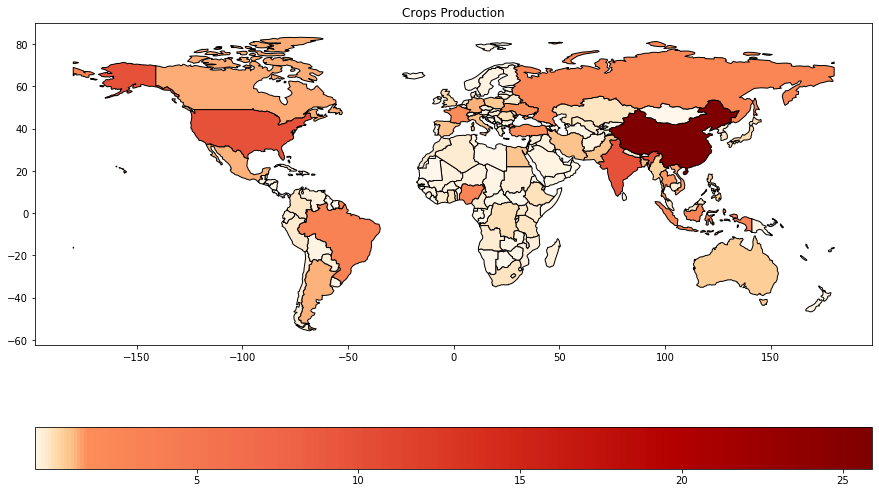

In [28]:
# world map
mapp(crops_production_total.Recent,'Crops Production')

We then define the functions `clean_df` and `clean_df_items` that do the cleaning we have seen so far. **We also save them in the helpers.py file**.

In [29]:
# clean_df_items function
def clean_df_items(df, items_list, to_drop, changes):
    df = df.replace(changes)
    df = df.loc[df['Item Code'].map(lambda x: x in items_list),]
    df = df.groupby(['Area','Item']).sum()
    df = df.drop(to_drop, axis=1)
    df = df.reset_index().set_index('Area')
    to_delete = set(df.index).difference(countries)
    df = df.drop(to_delete, axis=0)
    return df

In [30]:
# check if it works
crops_production = crops[crops['Element']=='Production']
crops_production = clean_df_items(crops_production,item_code_list,to_drop,changes)
crops_production.head()

,Item,Y1961,Y1962,Y1963,Y1964,Y1965,Y1966,Y1967,Y1968,Y1969,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
Area,,,,,,,,,,,,,,,,,,,,,
Afghanistan,"Cereals,Total",3695000.0,3696000.0,3378000.0,3732000.0,3785000.0,3489000.0,3826000.0,3916000.0,4038000.0,...,3950000.0,6514000.0,5957000.0,4681020.0,6379000.0,6520329.0,6748125.0,5809811.0,5534902.0,4897143.0
Afghanistan,Fibre Crops Primary,17000.0,26000.0,36700.0,26000.0,25000.0,20300.0,23100.0,23700.0,28700.0,...,11550.0,14148.0,10890.0,10890.0,11979.0,13917.0,14000.0,0.0,0.0,0.0
Afghanistan,Fruit Primary,567200.0,565000.0,571700.0,663800.0,715200.0,778700.0,913000.0,922000.0,933300.0,...,1244514.0,1459939.0,1360109.0,1274114.0,1352528.0,1346187.0,1714567.0,1832632.0,2602757.0,2496509.0
Afghanistan,"Oilcrops, Oil Equivalent",24700.0,28366.0,31752.0,28366.0,28796.0,28524.0,29380.0,30199.0,32352.0,...,19705.0,20717.0,19318.0,19620.0,19965.0,23083.0,23302.0,0.0,0.0,0.0
Afghanistan,"Pulses,Total",18000.0,18600.0,19600.0,20600.0,21700.0,22600.0,15000.0,24600.0,25600.0,...,51000.0,50000.0,53300.0,67000.0,69000.0,60000.0,60000.0,106842.0,82866.0,37287.0


In [31]:
# clean_df function
def clean_df(df, years, to_drop, changes):
    df = df.replace(changes)
    df = df.groupby('Area').sum()
    df = df.drop(to_drop, axis=1)
    to_delete = set(df.index).difference(countries)
    df = df.drop(to_delete, axis=0)
    sumCol = df.sum().rename("World")
    df['Recent'] = df[years].apply(norm).mean(axis=1)*100
    df = df.append(sumCol)
    df = df.sort_values(by=['Recent'], ascending=0)
    return df

In [32]:
# save data to pickle files
crops_production.to_pickle("pickle/crops_production.pkl")
crops_production_total.to_pickle("pickle/crops_production_total.pkl")

We now save and keep data related to yield.

In [33]:
crops_yield = crops[crops['Element']=='Yield']

In [34]:
item_code_list = [1717, 1720, 1726, 1729, 1732, 1735, 1738, 1753]
crops_yield = crops_yield.loc[crops_yield['Item Code'].map(lambda x: x in item_code_list),]

In [35]:
years = ['Y'+str(2000+x) for x in range(0,18)]
crops_yield = clean_df(crops_yield,years,to_drop,changes)

We drop the column `Recent` in this case, since it does not make sense for data about yield (productivity).

In [36]:
crops_yield = crops_yield.drop(columns='Recent')

In [37]:
crops_yield.head()

,Y1961,Y1962,Y1963,Y1964,Y1965,Y1966,Y1967,Y1968,Y1969,Y1970,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
Area,,,,,,,,,,,,,,,,,,,,,
Netherlands,10309213.0,8709157.0,11397142.0,20590999.0,15869033.0,17581410.0,21955184.0,20916277.0,26255165.0,30952516.0,...,1450537.0,1587502.0,1487264.0,1600585.0,1496329.0,1534360.0,1611168.0,1487763.0,1457313.0,1472804.0
Kuwait,469949.0,494779.0,494243.0,485248.0,539018.0,520494.0,540584.0,507009.0,487662.0,466530.0,...,1104809.0,1058074.0,1106851.0,1500985.0,1451111.0,1522896.0,1758175.0,1809033.0,1762580.0,1598256.0
Belgium,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1214710.0,1292339.0,1326985.0,1308802.0,1257651.0,1319304.0,1470368.0,1290658.0,1129253.0,1151305.0
United States of America,558186.0,564052.0,579468.0,556558.0,599020.0,596356.0,607510.0,608809.0,641269.0,641771.0,...,1108737.0,1145366.0,1116422.0,1128619.0,1137866.0,1153763.0,1162722.0,1151126.0,1164604.0,1143924.0
Iceland,481801.0,451553.0,435457.0,464066.0,544856.0,470150.0,509220.0,499624.0,449591.0,450091.0,...,1279426.0,1270472.0,1311136.0,1226944.0,1262965.0,1436276.0,1384170.0,1296796.0,1391299.0,1278578.0


In [38]:
crops_yield.to_pickle("pickle/crops_yield.pkl")

## Live Stock

We consider the dataset related to `live_stock`. For this analysis, we repeat more or less the same steps done before, in order to have a clear visualization of the phenomenon.

In [39]:
# Load dataset
live_stock = pd.read_csv('datasets/'+LIVE_STOCK, encoding = "ISO-8859-1")

In [40]:
live_stock.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Y1961,Y1962,Y1963,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
0,2,Afghanistan,1062,"Eggs, hen, in shell",5313,Laying,1000 Head,4000.0,4400.0,4600.0,...,9100.0,8700.0,8200.0,9600.0,9500.0,9500.0,9500.0,9337.0,9369.0,10688.0
1,2,Afghanistan,1062,"Eggs, hen, in shell",5410,Yield,100mg/An,25000.0,25000.0,25000.0,...,18349.0,19285.0,19932.0,17927.0,18947.0,18947.0,19474.0,21253.0,21263.0,18713.0
2,2,Afghanistan,1062,"Eggs, hen, in shell",5510,Production,tonnes,10000.0,11000.0,11500.0,...,16698.0,16778.0,16344.0,17210.0,18000.0,18000.0,18500.0,19844.0,19921.0,20000.0
3,2,Afghanistan,1067,"Eggs, hen, in shell (number)",5513,Production,1000 No,200000.0,220000.0,230000.0,...,333960.0,335560.0,326880.0,344200.0,360000.0,360000.0,370000.0,396880.0,398420.0,400000.0
4,2,Afghanistan,919,"Hides, cattle, fresh",5320,Producing Animals/Slaughtered,Head,360000.0,384000.0,396000.0,...,739000.0,750000.0,727800.0,766700.0,772000.0,744500.0,NaN,NaN,NaN,NaN


As for the `crops` dataset, we are interested in the `Production` only.

In [41]:
live_stock = live_stock[live_stock['Element']=='Production']

We now look at data in tonnes, i.e. `Unit` = `tonnes`.

In [42]:
live_stock = live_stock[live_stock['Unit']=='tonnes']
live_stock.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Y1961,Y1962,Y1963,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
2,2,Afghanistan,1062,"Eggs, hen, in shell",5510,Production,tonnes,10000.0,11000.0,11500.0,...,16698.0,16778.0,16344.0,17210.0,18000.0,18000.0,18500.0,19844.0,19921.0,20000.0
6,2,Afghanistan,919,"Hides, cattle, fresh",5510,Production,tonnes,7200.0,7680.0,7920.0,...,14780.0,15000.0,14556.0,15334.0,15440.0,14890.0,NaN,NaN,NaN,NaN
7,2,Afghanistan,1182,"Honey, natural",5510,Production,tonnes,2000.0,2000.0,2000.0,...,2800.0,2800.0,2000.0,2000.0,2000.0,2000.0,1802.0,1697.0,1584.0,1470.0
10,2,Afghanistan,1137,"Meat indigenous, camel",5510,Production,tonnes,3600.0,4031.0,5031.0,...,3780.0,3960.0,3960.0,3564.0,3600.0,3510.0,NaN,NaN,NaN,NaN
13,2,Afghanistan,944,"Meat indigenous, cattle",5510,Production,tonnes,42984.0,45811.0,47243.0,...,132342.0,134133.0,130922.0,138002.0,137723.0,117829.0,NaN,NaN,NaN,NaN


As for the previous dataset, in the `Item` columns, total productions for some categories are already computed, in particular:
* 1780: Milk, Total
* 1783: Eggs, Primary
* 1806: Beef and Buffalo Meat
* 1807: Sheep and Goat Meat
* 1808: Meat, poultry

In [43]:
# Meat dataset
item_code_list = set([1806,1807,1808])
live_stock_meat = live_stock.loc[live_stock['Item Code'].map(lambda x: x in item_code_list),]

In [44]:
# Milk dataset
live_stock_milk = live_stock.loc[live_stock['Item Code'].map(lambda x: x == 1780),]

In [45]:
# Eggs dataset
live_stock_eggs = live_stock.loc[live_stock['Item Code'].map(lambda x: x == 1783),]

For now, we will look only at meat data.

In [46]:
# Years to drop (before 2000) and columns to drop
years = ['Y'+str(2000+x) for x in range(0,18)]
to_drop = ['Area Code','Item Code','Element Code']

In [47]:
live_stock_meat = clean_df(live_stock_meat,years,to_drop,changes)
live_stock_meat.head(10)

,Y1961,Y1962,Y1963,Y1964,Y1965,Y1966,Y1967,Y1968,Y1969,Y1970,...,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017,Recent
Area,,,,,,,,,,,,,,,,,,,,,
United States of America,11108283.0,11010028.0,11600502.0,12645967.0,12962816.0,13700698.0,14040926.0,14181779.0,14473776.0,14997546.0,...,31136904.0,31490196.0,31843078.0,31795392.0,31957052.0,32179740.0,31874268.0,33032691.0,33898620.0,18.280105
China,872880.0,928682.0,1001807.0,1065075.0,1138600.0,1208580.0,1259011.0,1296894.0,1348860.0,1378922.0,...,26827815.0,27789070.0,28224045.0,29346735.0,29737874.0,29376616.0,29320089.0,30725690.0,30867086.0,14.965187
Brazil,1541221.0,1539041.0,1574174.0,1662963.0,1775594.0,1748133.0,1828112.0,2042617.0,2214589.0,2280742.0,...,19457470.0,20411526.0,21061680.0,21474402.0,22283083.0,22821594.0,23183704.0,23244122.0,23869943.0,10.990467
India,1492091.0,1533599.0,1550865.0,1583142.0,1611561.0,1639200.0,1674768.0,1711077.0,1734780.0,1768008.0,...,5371573.0,5543821.0,5828962.0,6021601.0,6206713.0,6390111.0,6538380.0,6700047.0,6802159.0,3.045945
Argentina,2365211.0,2605812.0,2827848.0,2249738.0,2295920.0,2641012.0,2862258.0,2919243.0,3232691.0,2997726.0,...,4979699.0,4357944.0,4399400.0,4613802.0,4856394.0,4725537.0,4933871.0,4806621.0,5064966.0,2.538297
Mexico,537956.0,619531.0,645394.0,673319.0,697846.0,714238.0,731773.0,748288.0,765445.0,767576.0,...,4479827.0,4566290.0,4711321.0,4752885.0,4750602.0,4845006.0,4946231.0,5094370.0,5277475.0,2.537615
Russia,4683000.0,5161000.0,5662000.0,5229000.0,5626000.0,6055000.0,6873000.0,7359000.0,7404000.0,7466000.0,...,4236649.0,4475419.0,4709973.0,5131406.0,5279865.0,5627729.0,5941418.0,5973414.0,6279799.0,2.451229
Australia,1276087.0,1450216.0,1582650.0,1655750.0,1692757.0,1623968.0,1563877.0,1671763.0,1723937.0,1888981.0,...,3636444.0,3683458.0,3723989.0,3821272.0,4154601.0,4488746.0,4568161.0,4292828.0,4020081.0,2.200370
France,2072700.0,2123900.0,2121700.0,2088800.0,2144000.0,2062900.0,2187250.0,2232300.0,2267067.0,2317875.0,...,3378855.0,3418297.0,3475550.0,3386810.0,3266839.0,3341321.0,3373285.0,3345102.0,3285681.0,2.078658


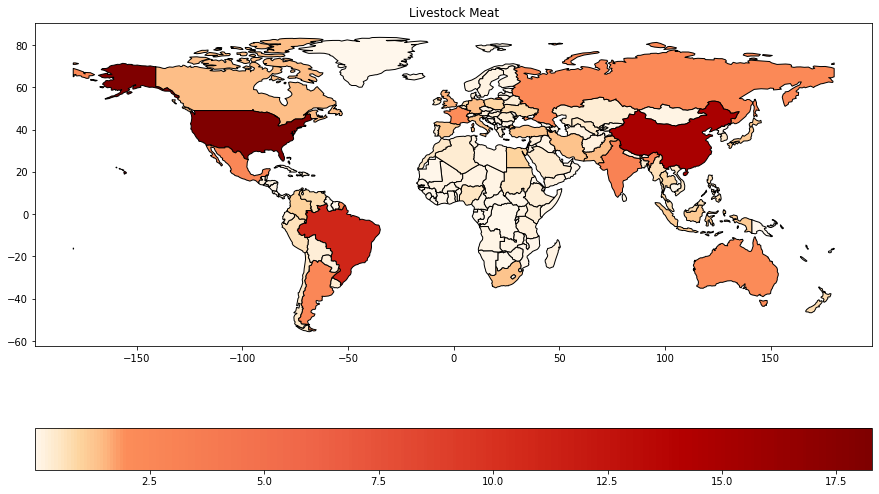

In [48]:
# World map
mapp(live_stock_meat.Recent,'Livestock Meat')

In [49]:
# save in pickle format
live_stock_meat.to_pickle("pickle/live_stock_meat.pkl")

# Production Value

In [50]:
# Load dataset
value_production = pd.read_csv('datasets/'+VALUE_PROD, encoding = "ISO-8859-1")

In [51]:
value_production.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Y1961,Y1962,Y1963,...,Y2007,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016
0,2,Afghanistan,221,"Almonds, with shell",152,Gross Production Value (constant 2004-2006 100...,1000 Int. $,NaN,NaN,NaN,...,92899.455089,123940.698000,127431.694327,165254.264000,178861.182059,182960.078000,124575.156335,80856.550600,71549.194374,96918.674867
1,2,Afghanistan,221,"Almonds, with shell",154,Net Production Value (constant 2004-2006 1000 I$),1000 Int. $,NaN,NaN,NaN,...,92899.455089,123940.698000,127431.694327,165254.264000,178861.182059,182960.078000,124575.156335,80856.550600,71549.194374,96918.674867
2,2,Afghanistan,221,"Almonds, with shell",56,Gross Production Value (current million SLC),SLC,NaN,NaN,NaN,...,5433.830473,8980.020000,8032.038000,12079.200000,13995.079900,14911.000000,9230.459191,5563.109132,4824.773367,6050.024466
3,2,Afghanistan,221,"Almonds, with shell",55,Gross Production Value (constant 2004-2006 mil...,SLC,NaN,NaN,NaN,...,3280.355179,4376.446667,4499.716581,5835.262222,6315.733546,6460.468889,4398.849906,2855.110444,2526.460140,3422.277092
4,2,Afghanistan,711,"Anise, badian, fennel, coriander",152,Gross Production Value (constant 2004-2006 100...,1000 Int. $,NaN,NaN,NaN,...,93962.672000,49744.944000,57275.009778,56377.603200,64207.463034,69090.200000,69090.200000,73114.852434,79457.968291,77478.699955


In this case, we choose to focus on the `Net Production Value`: other data from these dataset may turn out to be useful later.

In [52]:
# Select interesting data
value_production = value_production[value_production['Element']=='Net Production Value (constant 2004-2006 1000 I$)']

In this case, we select in the `Item` column, two aggregate values:
* 2041: `Crops (PIN)`
* 2044: `Livestock (PIN)`

In [53]:
value_production_crops = value_production[value_production.Item == 'Crops (PIN)']
value_production_livestock = value_production[value_production.Item == 'Livestock (PIN)']

In [54]:
# year for window
years = ['Y'+str(2000+x) for x in range(0,17)]

In [55]:
value_production_crops = clean_df(value_production_crops,years,to_drop,changes)
value_production_crops.head(10)

,Y1961,Y1962,Y1963,Y1964,Y1965,Y1966,Y1967,Y1968,Y1969,Y1970,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Recent
Area,,,,,,,,,,,,,,,,,,,,,
China,5.486383e+07,5.750877e+07,5.974875e+07,6.408849e+07,6.941861e+07,7.474186e+07,7.562914e+07,7.525090e+07,7.558269e+07,8.094671e+07,...,3.404799e+08,3.464848e+08,3.575270e+08,3.761136e+08,3.894069e+08,3.975741e+08,4.042520e+08,4.185934e+08,4.273472e+08,23.932196
India,4.713484e+07,4.670642e+07,4.808805e+07,4.936611e+07,4.648056e+07,4.605199e+07,4.959808e+07,5.204017e+07,5.385981e+07,5.723413e+07,...,1.581432e+08,1.521393e+08,1.684354e+08,1.807815e+08,1.836482e+08,1.911240e+08,1.946600e+08,1.882570e+08,1.926012e+08,11.163449
United States of America,5.372911e+07,5.421893e+07,5.653482e+07,5.437090e+07,5.936519e+07,5.799966e+07,6.114138e+07,6.363335e+07,6.438669e+07,6.112756e+07,...,1.250734e+08,1.307739e+08,1.307206e+08,1.256498e+08,1.243792e+08,1.344585e+08,1.418680e+08,1.408359e+08,1.507956e+08,9.133387
Brazil,1.506550e+07,1.594146e+07,1.603899e+07,1.581052e+07,1.892911e+07,1.734501e+07,1.910278e+07,1.913357e+07,1.965177e+07,2.010715e+07,...,7.868768e+07,7.685306e+07,8.186523e+07,8.759497e+07,8.458871e+07,9.088079e+07,9.228725e+07,9.595174e+07,9.217757e+07,5.289674
Indonesia,9.177546e+06,9.759697e+06,9.286465e+06,9.833857e+06,9.870585e+06,1.016386e+07,9.792827e+06,1.125288e+07,1.146786e+07,1.213493e+07,...,4.962030e+07,5.226148e+07,5.339329e+07,5.444798e+07,5.852421e+07,5.893397e+07,6.012049e+07,6.144981e+07,6.169739e+07,3.469374
Nigeria,6.966942e+06,7.299018e+06,7.705077e+06,7.926469e+06,8.307027e+06,8.085297e+06,8.427651e+06,8.585788e+06,9.574630e+06,1.053310e+07,...,3.239921e+07,2.798925e+07,3.245072e+07,2.990565e+07,3.337237e+07,3.238792e+07,3.658822e+07,3.731397e+07,3.692134e+07,2.216149
Turkey,8.083378e+06,8.253109e+06,8.677584e+06,8.964680e+06,8.727187e+06,9.631860e+06,9.870159e+06,1.044211e+07,1.009446e+07,1.094187e+07,...,2.564218e+07,2.626026e+07,2.671805e+07,2.804804e+07,2.869626e+07,2.924202e+07,2.784466e+07,2.994671e+07,3.029479e+07,1.896898
Argentina,5.898225e+06,6.044619e+06,6.686762e+06,7.101005e+06,6.449054e+06,6.807688e+06,7.724129e+06,6.613567e+06,7.059541e+06,7.716892e+06,...,2.735805e+07,1.942397e+07,2.723723e+07,2.919592e+07,2.549113e+07,2.839207e+07,3.050279e+07,3.295453e+07,3.340296e+07,1.800028
Thailand,4.707861e+06,5.059091e+06,5.481781e+06,5.302723e+06,5.514761e+06,6.546979e+06,5.721278e+06,6.196161e+06,6.685573e+06,6.921704e+06,...,2.473625e+07,2.505279e+07,2.500535e+07,2.726878e+07,2.935582e+07,2.921587e+07,2.872718e+07,2.689941e+07,2.603133e+07,1.775706


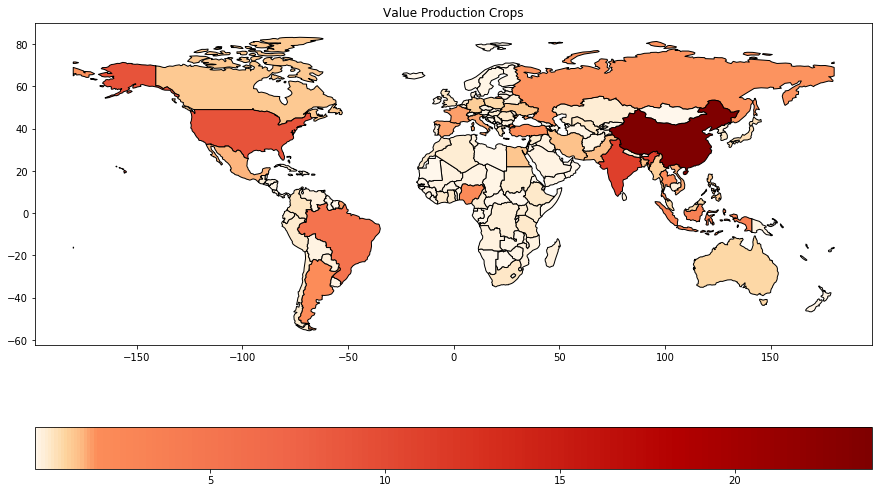

In [56]:
# World map
mapp(value_production_crops.Recent,'Value Production Crops')

In [57]:
value_production_livestock = clean_df(value_production_livestock,years,to_drop,changes)
value_production_livestock.head(10)

,Y1961,Y1962,Y1963,Y1964,Y1965,Y1966,Y1967,Y1968,Y1969,Y1970,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Recent
Area,,,,,,,,,,,,,,,,,,,,,
China,6.877012e+06,7.733043e+06,1.038102e+07,1.248867e+07,1.389358e+07,1.491376e+07,1.562281e+07,1.562529e+07,1.556785e+07,1.567819e+07,...,1.684752e+08,1.741849e+08,1.791699e+08,1.803484e+08,1.875000e+08,1.901574e+08,1.910274e+08,1.924339e+08,1.960145e+08,20.732250
United States of America,5.478356e+07,5.497088e+07,5.681435e+07,5.992497e+07,5.893877e+07,6.012625e+07,6.177911e+07,6.231170e+07,6.265957e+07,6.409075e+07,...,1.060030e+08,1.038576e+08,1.051870e+08,1.060553e+08,1.060117e+08,1.070630e+08,1.079421e+08,1.081007e+08,1.088873e+08,13.048083
India,1.190381e+07,1.195933e+07,1.198490e+07,1.196220e+07,1.201153e+07,1.216731e+07,1.238541e+07,1.297941e+07,1.321129e+07,1.309183e+07,...,5.565971e+07,5.759767e+07,6.000241e+07,6.228982e+07,6.408525e+07,6.623804e+07,6.953368e+07,7.273836e+07,7.419931e+07,7.018045
Brazil,6.778966e+06,6.925291e+06,7.001133e+06,7.513097e+06,7.939127e+06,7.986388e+06,8.169322e+06,8.921184e+06,9.357180e+06,9.579944e+06,...,5.525090e+07,5.518558e+07,5.778780e+07,5.889654e+07,6.017650e+07,6.318486e+07,6.358492e+07,6.342899e+07,6.296063e+07,6.698587
Germany,1.533766e+07,1.560843e+07,1.612714e+07,1.654482e+07,1.677472e+07,1.750011e+07,1.823053e+07,1.886935e+07,1.907669e+07,1.945295e+07,...,2.186489e+07,2.218662e+07,2.270131e+07,2.319470e+07,2.300499e+07,2.316580e+07,2.350510e+07,2.361331e+07,2.361364e+07,2.790345
Russia,3.790306e+07,4.040949e+07,4.224292e+07,3.945141e+07,4.307066e+07,4.595948e+07,4.920900e+07,5.062100e+07,5.070940e+07,5.200194e+07,...,2.209171e+07,2.267473e+07,2.312743e+07,2.357336e+07,2.417117e+07,2.445517e+07,2.454141e+07,2.462209e+07,2.470017e+07,2.767901
France,1.386665e+07,1.393470e+07,1.404411e+07,1.384160e+07,1.451958e+07,1.470123e+07,1.554382e+07,1.603151e+07,1.574146e+07,1.595220e+07,...,1.963665e+07,1.938139e+07,1.990317e+07,2.005497e+07,2.002518e+07,2.008029e+07,2.023598e+07,2.039521e+07,2.019879e+07,2.544637
Pakistan,3.115376e+06,3.208746e+06,3.289876e+06,3.385240e+06,3.466671e+06,3.512369e+06,3.596484e+06,3.690463e+06,3.790925e+06,3.886629e+06,...,1.780427e+07,1.843348e+07,1.911196e+07,1.978995e+07,2.047976e+07,2.120831e+07,2.164576e+07,2.213662e+07,2.156271e+07,2.230712
Mexico,3.245424e+06,3.551490e+06,3.505681e+06,3.505607e+06,3.684223e+06,4.047953e+06,4.169050e+06,4.345533e+06,4.546477e+06,4.543558e+06,...,1.613248e+07,1.650442e+07,1.689750e+07,1.765779e+07,1.752685e+07,1.748087e+07,1.758358e+07,1.773762e+07,1.784852e+07,2.031092


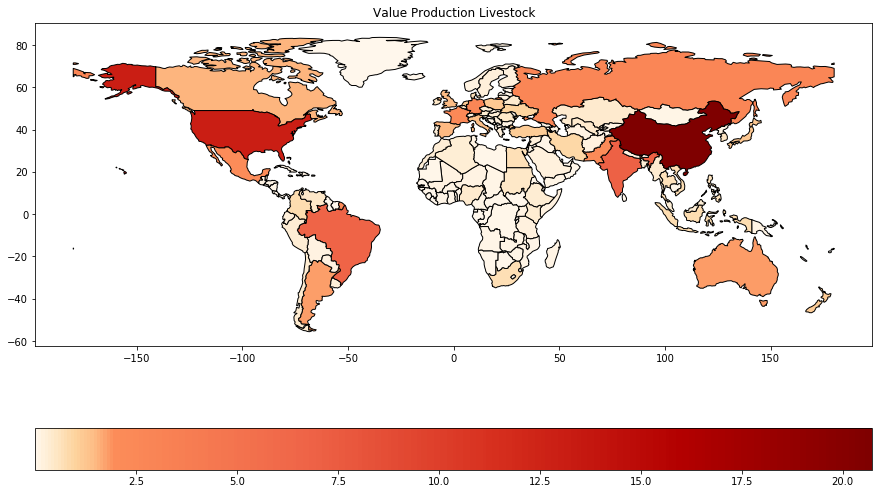

In [58]:
# World map
mapp(value_production_livestock.Recent,'Value Production Livestock')

In [59]:
value_production_crops.to_pickle("pickle/value_production_crops.pkl")
value_production_livestock.to_pickle("pickle/value_production_livestock.pkl")

## Interactive Map

In this section, we decide to build interactive maps to show time and space data together in the same visualization.

In [60]:
def interactive_df(df):
    df = df.drop(['World'])
    df = df.drop(['Recent'], axis=1)
    df = df.apply(norm)*100
    df.columns = df.columns.str.replace('Y', '')
    df = df.stack()
    df = df.reset_index()
    df = df.rename(columns={'level_1': 'Year', 0: 'Total'})
    df['Year'] = df['Year'].astype(int)
    return df

In [61]:
def mapp_interactive(result, world_df=world_df):
    year = np.mean(result['Year'])
    result = result.drop('Year', axis=1)
    merged = world_df.set_index('name').join(result)
    merged = merged.dropna(subset=['Total'])
    vmin, vmax, vcenter = merged.Total.min(), merged.Total.max(), merged.Total.quantile(0.9)
    divnorm = colors.DivergingNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
    ax = merged.plot(column='Total', figsize=(15,10), k=9, norm=divnorm, cmap='Greens', linewidth=1, edgecolor = "black",
                     legend=True, legend_kwds={'orientation': "horizontal"})
    ax.set_title(year,size=10)
    return

In [62]:
def plot_func(year):
    result = df
    result = result.set_index('Area')
    result = result[result['Year']==year]
    mapp_interactive(result)

### Crops Production interactive

In [63]:
interactive_crops = interactive_df(crops_production_total)
interactive_crops.head()

,Area,Year,Total
0,China,1961,15.429801
1,China,1962,15.718803
2,China,1963,15.496045
3,China,1964,15.268577
4,China,1965,16.774852


In [64]:
df = interactive_crops
range_year = (df['Year'].min(),df['Year'].max())
interact(plot_func, year = range_year)

interactive(children=(IntSlider(value=1989, description='year', max=2017, min=1961), Output()), _dom_classes=(…

<function __main__.plot_func(year)>

### Live Stock interactive

In [65]:
interactive_live_stock_meat = interactive_df(live_stock_meat)

In [66]:
df = interactive_live_stock_meat
range_year = (df['Year'].min(),df['Year'].max())
interact(plot_func, year = range_year)

interactive(children=(IntSlider(value=1989, description='year', max=2017, min=1961), Output()), _dom_classes=(…

<function __main__.plot_func(year)>

### Production value Crops interactive

In [67]:
interactive_value_crops = interactive_df(value_production_livestock)

In [68]:
df = interactive_value_crops
range_year = (df['Year'].min(),df['Year'].max())
interact(plot_func, year = range_year)

interactive(children=(IntSlider(value=1988, description='year', max=2016, min=1961), Output()), _dom_classes=(…

<function __main__.plot_func(year)>

In [69]:
interactive_value_livestock = interactive_df(value_production_crops)

# Emissions
In this section we analyze the total emissions in agriculture dataset from [FAO](http://www.fao.org/faostat/en/#data/GT).

In [70]:
# Import the dataset
emissions = pd.read_csv('datasets/'+EMISSIONS,encoding = "ISO-8859-1")

In [71]:
# See how it is organized
print(emissions.columns)
emissions.head()

Index(['Area Code', 'Area', 'Item Code', 'Item', 'Element Code', 'Element',
       'Unit', 'Y1961', 'Y1962', 'Y1963', 'Y1964', 'Y1965', 'Y1966', 'Y1967',
       'Y1968', 'Y1969', 'Y1970', 'Y1971', 'Y1972', 'Y1973', 'Y1974', 'Y1975',
       'Y1976', 'Y1977', 'Y1978', 'Y1979', 'Y1980', 'Y1981', 'Y1982', 'Y1983',
       'Y1984', 'Y1985', 'Y1986', 'Y1987', 'Y1988', 'Y1989', 'Y1990', 'Y1991',
       'Y1992', 'Y1993', 'Y1994', 'Y1995', 'Y1996', 'Y1997', 'Y1998', 'Y1999',
       'Y2000', 'Y2001', 'Y2002', 'Y2003', 'Y2004', 'Y2005', 'Y2006', 'Y2007',
       'Y2008', 'Y2009', 'Y2010', 'Y2011', 'Y2012', 'Y2013', 'Y2014', 'Y2015',
       'Y2016', 'Y2017', 'Y2030', 'Y2050'],
      dtype='object')


,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Y1961,Y1962,Y1963,...,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017,Y2030,Y2050
0,2,Afghanistan,5058,Enteric Fermentation,7225,Emissions (CH4),gigagrams,240.6831,245.3106,255.8285,...,401.0680,402.5130,396.9210,393.0930,398.2870,384.1370,381.6789,371.9253,453.7474,603.6185
1,2,Afghanistan,5058,Enteric Fermentation,7231,Emissions (CO2eq),gigagrams,5054.3459,5151.5228,5372.3989,...,8422.4280,8452.7730,8335.3410,8254.9530,8364.0270,8066.8761,8015.2578,7810.4313,9528.6962,12675.9880
2,2,Afghanistan,5058,Enteric Fermentation,7244,Emissions (CO2eq) from CH4,gigagrams,5054.3459,5151.5228,5372.3989,...,8422.4280,8452.7730,8335.3410,8254.9530,8364.0270,8066.8761,8015.2578,7810.4313,9528.6962,12675.9880
3,2,Afghanistan,5059,Manure Management,7225,Emissions (CH4),gigagrams,11.6228,11.9632,12.6064,...,26.5669,26.1599,26.0913,26.0859,26.3682,24.9017,24.7679,23.7619,27.2114,35.2700
4,2,Afghanistan,5059,Manure Management,7231,Emissions (CO2eq),gigagrams,367.8310,376.4362,392.5811,...,681.2759,678.8488,672.3300,667.6991,675.6191,645.1936,641.9611,623.3735,750.3240,1003.2279


In [72]:
# See the unique values of the interesting columns
def uniquevalues(df):
    for i in ['Item', 'Element', 'Unit']:
        print(i)
        print(df[i].unique())
uniquevalues(emissions)

Item
['Enteric Fermentation' 'Manure Management' 'Rice Cultivation'
 'Synthetic Fertilizers' 'Manure applied to Soils'
 'Manure left on Pasture' 'Crop Residues' 'Burning - Crop residues'
 'Burning - Savanna' 'Agriculture total' 'Agricultural Soils'
 'Cultivation of Organic Soils']
Element
['Emissions (CH4)' 'Emissions (CO2eq)' 'Emissions (CO2eq) from CH4'
 'Emissions (CO2eq) from N2O' 'Emissions (N2O)']
Unit
['gigagrams']


As we can see from the `Element` column, we have different emissions measurements. Among all we have the column `Emissions (CO2eq)` that is actually the sum of all the emissions converted into equivalent CO2 production. Therefore we decide to keep only these values.

In [73]:
# Keep only the CO2 equivalent values
emissions = emissions[emissions.Element=='Emissions (CO2eq)']

Considering the `Item` column, we can see that the emission production can be referred to different specific agriculture topics. We notice that we could specifically refer them to livestock or crop production. Therefore we decide to split the dataset into two different datasets.

The dataset `emissions_livestock` contains the emissions referred to:
* 'Enteric Fermentation'
* 'Manure Management'
* 'Manure left on Pature'

The dataset `emissions_crops` contains the emissions referred to:
* 'Synthetic Fertilizers'
* 'Manure applied to Soils'
* 'Crop Residues'
* 'Burning - Crop residues'
* 'Burning - Savanna'
* 'Rice Cultivation'
* 'Cultivation of Organic Soils'

In [74]:
# Create the livestock emissions dataset
emissions_livestock = emissions[(emissions.Item=='Enteric Fermentation')\
                     | (emissions.Item=='Manure Management')\
                     | (emissions.Item=='Manure left on Pasture')]

In [75]:
# Create the crops emissions dataset
emissions_crops = emissions[(emissions.Item=='Synthetic Fertilizers')\
                     | (emissions.Item=='Manure applied to Soils')\
                     | (emissions.Item=='Crop Residues')\
                     | (emissions.Item=='Burning - Crop residues')\
                     | (emissions.Item=='Burning - Savanna')\
                     | (emissions.Item=='Rice Cultivation')\
                     | (emissions.Item=='Cultivation of Organic Soils')]

For this dataset we also have predictions for the emissions in 2030 and 2050: we decide to keep them as they might be useful for further analyses.

In [76]:
# prepare for cleaning
years = ['Y'+str(2000+x) for x in range(0,18)]
to_drop = ['Area Code','Item Code','Element Code']

We then use the previously defined function `clean_df` that we use to clean the datasets.

In [77]:
# Clean live stock dataset
emissions_livestock = clean_df(emissions_livestock,years,to_drop,changes)

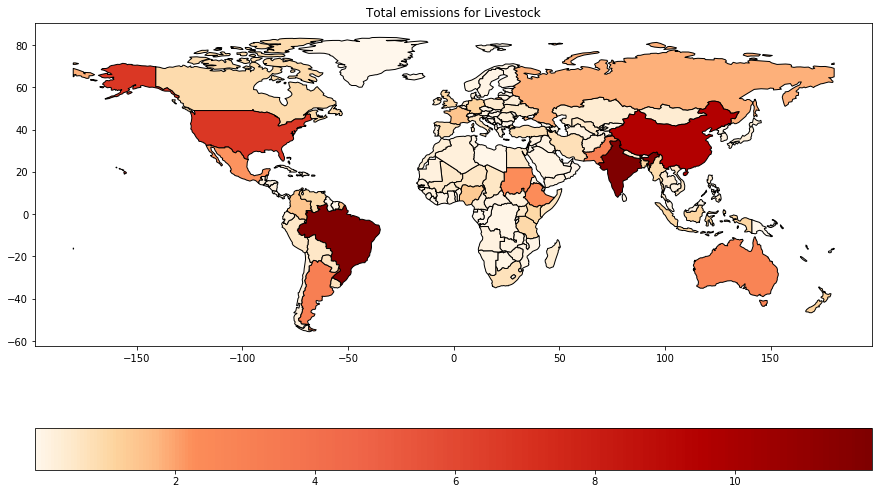

In [78]:
# World map
mapp(emissions_livestock.Recent,'Total emissions for Livestock')

In [79]:
# Clean crops dataset
emissions_crops = clean_df(emissions_crops,years,to_drop,changes)

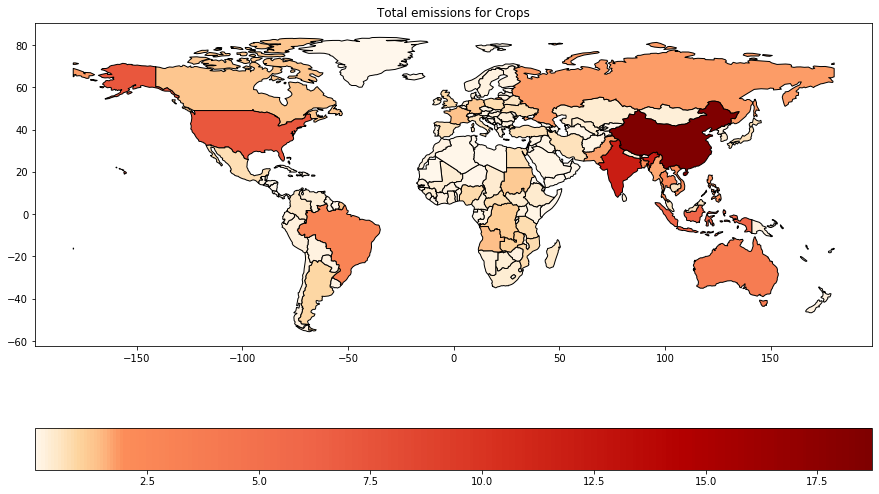

In [80]:
# World map
mapp(emissions_crops.Recent,'Total emissions for Crops')

In [81]:
# Live stock interactive map
interactive_emissions_livestock = interactive_df(emissions_livestock)

In [82]:
df = interactive_emissions_livestock
range_year = (df['Year'].min(),df['Year'].max())
interact(plot_func, year = range_year)

interactive(children=(IntSlider(value=2005, description='year', max=2050, min=1961), Output()), _dom_classes=(…

<function __main__.plot_func(year)>

In [83]:
# Crops interactive map
interactive_emissions_crops = interactive_df(emissions_crops)

In [84]:
df = interactive_emissions_crops
range_year = (df['Year'].min(),2017)
interact(plot_func, year = range_year)

interactive(children=(IntSlider(value=1989, description='year', max=2017, min=1961), Output()), _dom_classes=(…

<function __main__.plot_func(year)>

In [85]:
emissions_livestock.to_pickle("pickle/emissions_livestock.pkl")
emissions_crops.to_pickle("pickle/emissions_crops.pkl")

# Fertilizers
We now consider the fertilizers use datasets. For this topic we do not have a unique dataset but we actually consider three different ones since FAO in 2002 changed the way they collected the data. Until 2002 they had a unique dataset called `fertilizers archive`, then they changed the classification methods and decided to have three different datasets:
* `fertilizers by nutrient` containing information on the totals separately for the three main plant nutrients nitrogen (N), phosphate (P2O5) and potash (K2O);
* `fertilizers by product` containing information on fertilizing products amounts;
* `fertilizers indicators` containing the use of fertilizers per area of cropland grouped into the three main plant nutrients.

In order to provide a unique dataset we have to go further in understanding how the data is organized. So let's import them and have a look.

In [86]:
# Import the datasets
fert_a = pd.read_csv('datasets/'+FERT_A, encoding = "ISO-8859-1")
fert_n = pd.read_csv('datasets/'+FERT_N, encoding = "ISO-8859-1")
fert_p = pd.read_csv('datasets/'+FERT_P, encoding = "ISO-8859-1")
fert_i = pd.read_csv('datasets/'+FERT_I, encoding = "ISO-8859-1")

In [87]:
fert_a.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Y1961,Y1961F,Y1962,...,Y1998,Y1998F,Y1999,Y1999F,Y2000,Y2000F,Y2001,Y2001F,Y2002,Y2002F
0,2,Afghanistan,1402,Ammonia,5510,Production,tonnes,0.0,NR,0.0,...,0.0,NR,0.0,NR,0.0,NR,0.0,NR,0.0,NR
1,2,Afghanistan,1402,Ammonia,5610,Import Quantity,tonnes,0.0,NR,0.0,...,0.0,NR,0.0,NR,0.0,NR,0.0,NR,0.0,NR
2,2,Afghanistan,1402,Ammonia,5910,Export Quantity,tonnes,0.0,NR,0.0,...,0.0,NR,0.0,NR,0.0,NR,0.0,NR,0.0,NR
3,2,Afghanistan,1402,Ammonia,5157,Agricultural Use,tonnes,0.0,NR,0.0,...,0.0,NR,0.0,NR,0.0,NR,0.0,NR,0.0,NR
4,2,Afghanistan,1402,Ammonia,5751,Prices Paid by Farmers,LCU/mt,0.0,NR,0.0,...,0.0,NR,0.0,NR,0.0,NR,0.0,NR,0.0,NR


In [88]:
fert_p.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Y2002,Y2003,Y2004,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
0,2,Afghanistan,4007,"Ammonia, anhydrous",5610,Import Quantity,tonnes,NaN,NaN,NaN,...,NaN,NaN,NaN,4.49,NaN,NaN,2.00,NaN,NaN,2.07
1,2,Afghanistan,4007,"Ammonia, anhydrous",5622,Import Value,1000 US$,NaN,NaN,NaN,...,NaN,NaN,NaN,2.69,NaN,NaN,1.07,NaN,NaN,1.24
2,2,Afghanistan,4003,Ammonium nitrate (AN),5610,Import Quantity,tonnes,1786.13,NaN,NaN,...,NaN,NaN,NaN,NaN,1456.8,1.0,NaN,NaN,NaN,NaN
3,2,Afghanistan,4003,Ammonium nitrate (AN),5622,Import Value,1000 US$,123.24,NaN,NaN,...,NaN,NaN,NaN,NaN,445.8,2.8,NaN,NaN,NaN,NaN
4,2,Afghanistan,4002,Ammonium sulphate,5610,Import Quantity,tonnes,NaN,0.14,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.0,NaN


In [89]:
fert_n.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Y2002,Y2003,Y2004,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
0,2,Afghanistan,3102,Nutrient nitrogen N (total),5510,Production,tonnes,23414.00,16206.00,19458.00,...,15324.00,13606.00,12022.00,17555.00,15776.00,15694.00,14416.00,14416.00,14416.00,14416.00
1,2,Afghanistan,3102,Nutrient nitrogen N (total),5610,Import Quantity,tonnes,1132.46,4233.77,2905.48,...,4.68,1001.89,914.39,5411.94,1289.25,19223.36,59482.34,6659.57,82277.39,126363.30
2,2,Afghanistan,3102,Nutrient nitrogen N (total),5910,Export Quantity,tonnes,22.93,32.75,23.79,...,896.65,452.01,7.38,0.00,0.00,13.57,27.14,0.00,22.55,5.14
3,2,Afghanistan,3102,Nutrient nitrogen N (total),5157,Agricultural Use,tonnes,24523.53,20407.02,22339.69,...,14432.03,14155.88,12929.01,22970.63,17065.25,34903.79,73872.84,21075.57,96670.85,140775.85
4,2,Afghanistan,3103,Nutrient phosphate P2O5 (total),5510,Production,tonnes,0.00,0.00,NaN,...,NaN,NaN,NaN,1563.00,460.00,1539.00,1541.00,1541.00,1541.00,1541.00


In [90]:
fert_i.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Y2002,Y2003,Y2004,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
0,2,Afghanistan,3102,Nutrient nitrogen N (total),5159,Use per area of cropland,kg/ha,3.16,2.58,2.82,...,1.82,1.79,1.63,2.90,2.16,4.41,9.34,2.66,12.22,17.80
1,2,Afghanistan,3103,Nutrient phosphate P2O5 (total),5159,Use per area of cropland,kg/ha,0.00,0.84,1.36,...,0.00,0.07,0.12,0.87,0.16,0.38,0.65,1.28,1.14,2.11
2,2,Afghanistan,3104,Nutrient potash K2O (total),5159,Use per area of cropland,kg/ha,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.02,0.01,0.00,0.00,0.01,0.00
3,3,Albania,3102,Nutrient nitrogen N (total),5159,Use per area of cropland,kg/ha,54.67,53.47,51.67,...,41.24,48.76,44.96,53.01,50.21,44.11,44.13,52.87,60.98,56.70
4,3,Albania,3103,Nutrient phosphate P2O5 (total),5159,Use per area of cropland,kg/ha,26.02,28.65,31.94,...,25.81,29.96,31.08,33.54,31.85,32.90,32.91,41.27,49.10,30.77


In [91]:
def uniquevalues(df):
    for i in ['Item', 'Element', 'Unit']:
        print(i)
        print(df[i].unique())

In [92]:
uniquevalues(fert_a)

Item
['Ammonia' 'Ammonium nitrate (AN)' 'Ammonium Phosphat (P2o5)'
 'Ammonium Phosphate (N)' 'Ammonium sulphate' 'Ammonium SulphateNitrate'
 'Basic Slag' 'Calcium ammonium nitrate' 'Calcium Cyanamide'
 'Calcium Nitrate' 'Complex Fertilizer (K2o)' 'Concent Superphosphate'
 'Crude Salts To 20% K2o' 'Ground Rock Phosphate' 'Muriate 20-45% K2o'
 'Muriate Over 45% K2o' 'Nitrogenous fertilizers'
 'Oth Complex Fert (P2o5)' 'Other Complex Fert (N)'
 'Other nitrogenous fertilizers, n.e.c.'
 'Other phosphatic fertilizers, n.e.c.\r\n'
 'Other potassic fertilizers, n.e.c.' 'Phosphate fertilizers'
 'Potash fertilizers' 'Potassium sulphate (sulphate of potash) (SOP)'
 'Single Superphosphate' 'Sodium Nitrate' 'Urea' 'Total Fertilizers'
 'Phosphoric Acid']
Element
['Production' 'Import Quantity' 'Export Quantity' 'Agricultural Use'
 'Prices Paid by Farmers']
Unit
['tonnes' 'LCU/mt']


As previously said, for the first three dasets we are going to select only the element `Agricultural Use`. Since in the dataset `fertilizers indicators` we only have the amount of fertilizer used per cropland, we are initially not going to consider this dataset. We may will consider it later if it will be needed. 

In [93]:
fert_a = fert_a[fert_a.Element=='Agricultural Use']
fert_p = fert_p[fert_p.Element=='Agricultural Use']
fert_n = fert_n[fert_n.Element=='Agricultural Use']

In [94]:
# Check Unit
fert_a.Unit.unique(), fert_p.Unit.unique(), fert_n.Unit.unique()

(array(['tonnes'], dtype=object),
 array(['tonnes'], dtype=object),
 array(['tonnes'], dtype=object))

In [95]:
# Get the total sum from a by nutrient categorization on fertilizers archive
fert_a_n = fert_a[(fert_a.Item=='Nitrogenous fertilizers')\
          | (fert_a.Item=='Phosphate fertilizers')\
          | (fert_a.Item=='Potash fertilizers')]\
          .groupby('Area').sum()
fert_a_n.Y2002.head()

Area
Afghanistan       20800.0
Africa          4278401.0
Albania           35357.0
Algeria           98000.0
Americas       35142135.0
Name: Y2002, dtype: float64

In [96]:
# Get the total sum from a by product categorization on fertilizers archive
fert_a_p = fert_a[(fert_a.Item!='Nitrogenous fertilizers')\
          & (fert_a.Item!='Phosphate fertilizers')\
          & (fert_a.Item!='Potash fertilizers')\
          & (fert_a.Item!='Total Fertilizers') ]\
          .groupby(['Area']).sum()
fert_a_p.Y2002.head()

Area
Afghanistan         20800.0
Africa            3567481.0
Albania             35357.0
Algeria                 0.0
American Samoa          0.0
Name: Y2002, dtype: float64

As we can see we now found how the dataset `fertilizers archive` categorizes the data. It seems that we could obtain the same total amount of fertilizer used from the two methods (by nutrient or by product) but still information is lacking from the categorization by product. From the `fertilizers archive` dataset we therefore decide to keep only the total amount of fertilizers used yearly for each country by keeping only the items `Total Fertilizers`.

Concerning the `fertilizers by nutrient` dataset we read from the [FAO website](http://fenixservices.fao.org/faostat/static/documents/RFN/RFN_EN_README.pdf) that the nutrients are calculated by also taking into account the compound fertilizers that, however, are not considered in the `fertilizers archive`.
This explains why we obtain results that are close but still different from the two totals of the two datasets.

Since in our analysis we are now interested in percentages rather than precise values of fertilizers use, from now on we are going to consider the `fertilizers by nutrient` for the years from 2002 on and the `Total Fertilizers` items from the `fertilizeers archive` for years before 2002.

We are now goint to put them together but first we need to drop the `Flag` columns (that say how data was calculated) from the `fertilizers archive`.

In [97]:
# Drop the flag years and the year 2002 from fertilizers archive
years_drop = ['Y'+str(1900+x)+'F' for x in range(61,100)] + ['Y'+str(2000+x)+'F' for x in range(0,3)]+['Y2002']
fert_a = fert_a.drop(years_drop, axis=1)

In [98]:
# Filter only the Total Fertilizers items
fert_a = fert_a[fert_a.Item=='Total Fertilizers']
fert_a = fert_a.replace(changes)
fert_a.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Y1961,Y1962,Y1963,...,Y1992,Y1993,Y1994,Y1995,Y1996,Y1997,Y1998,Y1999,Y2000,Y2001
143,2,Afghanistan,1818,Total Fertilizers,5157,Agricultural Use,tonnes,1100.0,1100.0,1100.0,...,45800.0,40000.0,0.0,0.0,5000.0,5000.0,7000.0,5000.0,5000.0,18400.0
293,3,Albania,1818,Total Fertilizers,5157,Agricultural Use,tonnes,6302.0,5200.0,5300.0,...,23500.0,17890.0,14770.0,11000.0,6500.0,5200.0,25000.0,10600.0,18700.0,18700.0
443,4,Algeria,1818,Total Fertilizers,5157,Agricultural Use,tonnes,49000.0,55000.0,53000.0,...,96800.0,130900.0,119300.0,46400.0,38000.0,97000.0,108000.0,93000.0,92300.0,105300.0
603,7,Angola,1818,Total Fertilizers,5157,Agricultural Use,tonnes,1000.0,1000.0,1400.0,...,9100.0,8000.0,10000.0,8000.0,6000.0,2000.0,3400.0,3400.0,1400.0,0.0
758,9,Argentina,1818,Total Fertilizers,5157,Agricultural Use,tonnes,16241.0,12711.0,21080.0,...,248200.0,293900.0,462000.0,524700.0,855200.0,809600.0,775500.0,823500.0,862983.0,861991.0


In [99]:
# Calculate the total use on the fertilizers by nutrient dataset
fert_n = fert_n.replace(changes)
fert_n = fert_n.groupby(['Area']).sum().drop(['Area Code','Item Code','Element Code'], axis=1)
fert_n.head()

,Y2002,Y2003,Y2004,Y2005,Y2006,Y2007,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
Area,,,,,,,,,,,,,,,,
Afghanistan,24526.53,27035.26,33169.37,29774.39,24869.52,16377.29,14432.03,14712.11,13854.86,29816.20,18523.47,38011.93,79000.86,31232.39,105733.85,157464.02
Africa,4117961.79,4526013.11,4694822.50,4502916.67,4395095.09,4422820.77,5042626.73,4391993.97,5507875.99,5234137.06,5442198.67,5565927.83,5962381.02,5670156.19,5942546.50,6503404.15
Albania,56404.00,57406.71,58555.64,60457.92,50108.64,51106.74,47158.94,55040.42,53224.98,60604.12,57614.41,54410.38,54410.30,66327.00,78243.70,61082.86
Algeria,72765.00,45031.00,188038.00,55806.00,99072.00,111748.00,64231.00,107000.00,118500.00,118300.00,160100.00,168300.00,190500.00,175600.00,155700.00,155700.00
Americas,35120342.52,38073447.14,40713476.39,37527532.77,38521459.24,42447632.31,38469890.76,33291895.38,39107790.21,44887837.66,45047835.97,47188778.26,47690069.87,44500444.18,47394970.46,50227671.05


In [100]:
# Create a unique dataset
fertilizers = fert_a.set_index('Area').join(fert_n)

In [101]:
fertilizers.head()

,Area Code,Item Code,Item,Element Code,Element,Unit,Y1961,Y1962,Y1963,Y1964,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
Area,,,,,,,,,,,,,,,,,,,,,
Afghanistan,2,1818,Total Fertilizers,5157,Agricultural Use,tonnes,1100.0,1100.0,1100.0,1100.0,...,14432.03,14712.11,13854.86,29816.20,18523.47,38011.93,79000.86,31232.39,105733.85,157464.02
Africa,5100,1818,Total Fertilizers,5157,Agricultural Use,tonnes,716141.0,780262.0,879628.0,996966.0,...,5042626.73,4391993.97,5507875.99,5234137.06,5442198.67,5565927.83,5962381.02,5670156.19,5942546.50,6503404.15
Albania,3,1818,Total Fertilizers,5157,Agricultural Use,tonnes,6302.0,5200.0,5300.0,6400.0,...,47158.94,55040.42,53224.98,60604.12,57614.41,54410.38,54410.30,66327.00,78243.70,61082.86
Algeria,4,1818,Total Fertilizers,5157,Agricultural Use,tonnes,49000.0,55000.0,53000.0,52500.0,...,64231.00,107000.00,118500.00,118300.00,160100.00,168300.00,190500.00,175600.00,155700.00,155700.00
Americas,5200,1818,Total Fertilizers,5157,Agricultural Use,tonnes,9027226.0,10161226.0,11335980.0,11908846.0,...,38469890.76,33291895.38,39107790.21,44887837.66,45047835.97,47188778.26,47690069.87,44500444.18,47394970.46,50227671.05


In [102]:
# define years window
years = ['Y'+str(2000+x) for x in range(0,17)]

We then use the previously defined function `clean_df` that we use to clean the datasets.

In [103]:
# Clean dataset
fertilizers = clean_df(fertilizers,years,to_drop,changes)
fertilizers.head()

,Y1961,Y1962,Y1963,Y1964,Y1965,Y1966,Y1967,Y1968,Y1969,Y1970,...,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017,Recent
Area,,,,,,,,,,,,,,,,,,,,,
China,728000.0,989600.0,1247000.0,1677000.0,2604000.0,3719000.0,2697000.0,2696000.0,3474000.0,4407000.0,...,47015712.03,51511621.90,53182047.83,54078095.65,53779194.72,55618943.32,54558935.73,53724192.41,52995366.31,28.248659
India,338300.0,452200.0,543900.0,773200.0,784600.0,1100600.0,1539000.0,1760700.0,1982000.0,2256600.0,...,26445526.00,28110244.00,28373686.00,25536100.00,24482500.00,25581400.00,26752600.00,25949900.00,26593400.00,13.567807
United States of America,7646496.0,8604260.0,9474315.0,9953907.0,11276278.0,12676548.0,13645012.0,14074587.0,14577261.0,15535480.0,...,17137601.00,18262765.00,20070761.00,20565302.10,20994055.00,20660881.00,20211336.00,20544035.00,20459267.00,11.992508
Brazil,270004.0,256082.0,297782.0,247651.0,278878.0,276059.0,447925.0,601709.0,630384.0,1001917.0,...,7540435.57,10424767.72,13081009.13,12116475.02,14147326.89,15363337.57,12809826.43,14523279.55,16582859.11,6.310013
Indonesia,135990.0,149396.0,130000.0,96242.0,94498.0,145004.0,126700.0,271408.0,178007.0,240193.0,...,4286696.00,4283793.00,4662837.00,5203810.20,5159718.30,5460675.20,5443037.13,5444238.66,5824967.75,2.391433


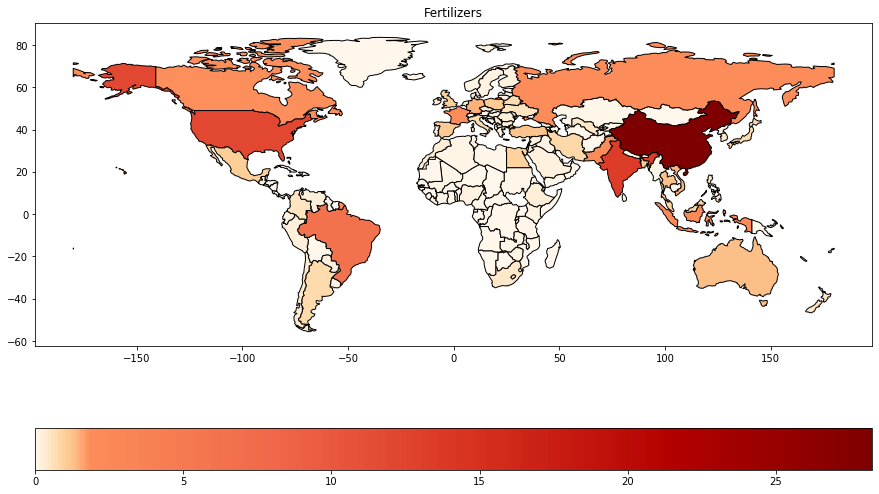

In [104]:
# World map
mapp(fertilizers.Recent,'Fertilizers')

In [105]:
# Interactive map
interactive_fertilizers = interactive_df(fertilizers)

In [106]:
df = interactive_fertilizers
range_year = (df['Year'].min(),df['Year'].max())
interact(plot_func, year = range_year)

interactive(children=(IntSlider(value=1989, description='year', max=2017, min=1961), Output()), _dom_classes=(…

<function __main__.plot_func(year)>

In [107]:
fertilizers.to_pickle("pickle/fertilizers.pkl")

# Pesticides

In [108]:
# Load dataset
pesticides = pd.read_csv('datasets/'+PESTICIDES, encoding = "ISO-8859-1")
pesticides.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Y1990,Y1991,Y1992,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
0,3,Albania,1357,Pesticides (total),5157,Agricultural Use,tonnes,121.0,121.0,121.0,...,392.6,403.49,582.93,574.62,353.05,441.53,447.89,590.41,656.52,681.14
1,3,Albania,1309,Insecticides,5157,Agricultural Use,tonnes,NaN,NaN,NaN,...,NaN,213.88,375.80,317.07,157.57,214.13,34.48,184.59,226.30,237.59
2,3,Albania,1310,Insecticides  Chlorinated Hydrocarbons,5157,Agricultural Use,tonnes,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Albania,1311,Insecticides  Organo-phosphates,5157,Agricultural Use,tonnes,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3,Albania,1312,Insecticides  Carbamates,5157,Agricultural Use,tonnes,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


To have a general idea on the use of pesticides, we focus on the their total amount.

In [109]:
pesticides = pesticides[pesticides.Item=='Pesticides (total)']

In [110]:
# Clean dataset
years = ['Y'+str(2000+x) for x in range(0,18)]
to_drop = ['Area Code','Item Code','Element Code']
pesticides = clean_df(pesticides,years,to_drop,changes)
pesticides.head()

,Y1990,Y1991,Y1992,Y1993,Y1994,Y1995,Y1996,Y1997,Y1998,Y1999,...,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017,Recent
Area,,,,,,,,,,,,,,,,,,,,,
China,775408.37,775388.37,809244.37,854860.37,988608.37,1097075.37,1150843.77,1204908.17,1240708.57,1333139.97,...,1717687.15,1765944.22,1795371.35,1815505.77,1811604.85,1815732.79,1772420.36,1772588.89,1773634.40,43.678972
United States of America,400975.93,384646.39,400975.90,391903.86,425922.68,423201.53,433180.36,434540.76,424562.11,433633.96,...,358337.70,374818.20,391298.70,407779.20,407779.20,407779.20,407779.20,407779.20,407779.20,11.072901
Brazil,49695.00,58349.44,67003.89,75658.33,84312.78,92967.22,101621.67,110276.11,118930.56,127585.00,...,335742.00,342580.00,345026.00,346583.00,367778.00,352336.00,395646.00,377176.00,377176.00,7.618887
Argentina,26156.00,26156.00,26156.00,26156.00,30195.00,37842.00,54595.00,77691.00,62397.00,73152.15,...,138831.47,234430.38,219255.93,215405.95,211555.98,207706.00,203806.98,199907.95,196008.93,4.483995
France,97701.00,103434.00,85249.00,91953.00,89515.00,84011.00,97890.00,109793.00,107754.00,114696.00,...,63692.00,61911.00,61039.00,63547.59,66497.29,74909.60,66531.02,71951.22,70588.70,2.069175


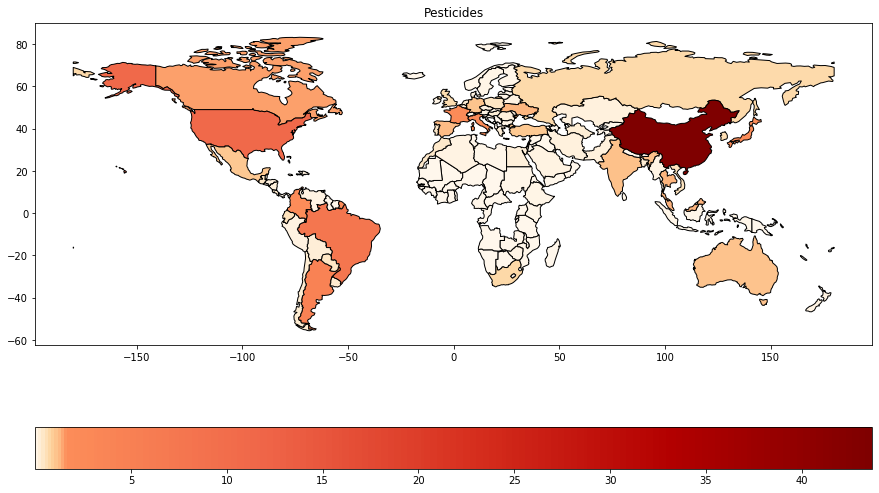

In [111]:
# World map
mapp(pesticides.Recent,'Pesticides')

In [112]:
# Interactive map
interactive_pesticides = interactive_df(pesticides)

In [113]:
df = interactive_pesticides
range_year = (df['Year'].min(),df['Year'].max())
interact(plot_func, year = range_year)

interactive(children=(IntSlider(value=2003, description='year', max=2017, min=1990), Output()), _dom_classes=(…

<function __main__.plot_func(year)>

In [114]:
pesticides.to_pickle("pickle/pesticides.pkl")

# International Trade

In [115]:
# Load dataset
trade = pd.read_csv('datasets/'+TRADE, encoding = "ISO-8859-1")
trade.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Y1961,Y1962,Y1963,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
0,2,Afghanistan,231,Almonds shelled,5610,Import Quantity,tonnes,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,167.0,181.0,845.0,102.0
1,2,Afghanistan,231,Almonds shelled,5622,Import Value,1000 US$,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1116.0,1377.0,4988.0,758.0
2,2,Afghanistan,231,Almonds shelled,5910,Export Quantity,tonnes,0.0,0.0,0.0,...,2917.0,4763.0,1308.0,2262.0,1125.0,2381.0,2716.0,2342.0,1691.0,3335.0
3,2,Afghanistan,231,Almonds shelled,5922,Export Value,1000 US$,0.0,0.0,0.0,...,14784.0,35476.0,15893.0,20270.0,9647.0,18617.0,16453.0,17808.0,11954.0,23248.0
4,2,Afghanistan,711,"Anise, badian, fennel, coriander",5610,Import Quantity,tonnes,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,284.0,1000.0,815.0,38.0


In the `trade` dataset, we have import and export quantities and values for a number of different `Item` i.e. vegetables and fruits. We focus on the value only, and divide the data into two dataframe, `trade_import` and `trade_export`.

In [116]:
trade_import = trade[trade.Element=='Import Value']
trade_import.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Y1961,Y1962,Y1963,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
1,2,Afghanistan,231,Almonds shelled,5622,Import Value,1000 US$,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1116.0,1377.0,4988.0,758.0
5,2,Afghanistan,711,"Anise, badian, fennel, coriander",5622,Import Value,1000 US$,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,599.0,2041.0,1669.0,97.0
9,2,Afghanistan,515,Apples,5622,Import Value,1000 US$,0.0,0.0,0.0,...,131.0,553.0,9743.0,990.0,500.0,166.0,20129.0,800.0,31173.0,88287.0
13,2,Afghanistan,526,Apricots,5622,Import Value,1000 US$,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0
17,2,Afghanistan,527,"Apricots, dry",5622,Import Value,1000 US$,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.0,2.0,40.0,9.0


In [117]:
trade_export = trade[trade.Element=='Export Value']
trade_export.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Y1961,Y1962,Y1963,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
3,2,Afghanistan,231,Almonds shelled,5922,Export Value,1000 US$,0.0,0.0,0.0,...,14784.0,35476.0,15893.0,20270.0,9647.0,18617.0,16453.0,17808.0,11954.0,23248.0
7,2,Afghanistan,711,"Anise, badian, fennel, coriander",5922,Export Value,1000 US$,NaN,NaN,NaN,...,1843.0,6888.0,8771.0,4428.0,4511.0,8133.0,70841.0,37709.0,26898.0,16002.0
11,2,Afghanistan,515,Apples,5922,Export Value,1000 US$,0.0,0.0,0.0,...,3664.0,4683.0,719.0,1201.0,7689.0,10387.0,4750.0,15918.0,25788.0,15087.0
15,2,Afghanistan,526,Apricots,5922,Export Value,1000 US$,0.0,0.0,0.0,...,3330.0,10915.0,2455.0,1793.0,1584.0,3678.0,5885.0,4437.0,6536.0,7069.0
19,2,Afghanistan,527,"Apricots, dry",5922,Export Value,1000 US$,0.0,0.0,0.0,...,9671.0,6331.0,9982.0,8193.0,9357.0,16365.0,11092.0,11403.0,6454.0,20664.0


In this case, by inspecting the `Item` column, we can detect the most important aggregate values we could use for our analysis. We decide to divide the data into the usual two groups: crops and livestock. To be consistent with the `value_production` dataset, we keep and sum the following items to build the two datasets:

For `_crops` dataset:
* 1944: `Cereals`
* 1889: `Fruit and Vegetables`
* 1899, 1903, 1905: `Oil`

For `_livestock` dataset:
* 1886: `Diary Products + Eggs`
* 2077: `Total Meat`

In [118]:
item_code_crops = [1944, 1889, 1899, 1903, 1905]
item_code_livestock = [1886, 2077]

In [119]:
trade_import_crops = trade_import.loc[trade_import['Item Code'].map(lambda x: x in item_code_crops),]
trade_import_livestock = trade_import.loc[trade_import['Item Code'].map(lambda x: x in item_code_livestock),]
trade_export_crops = trade_export.loc[trade_export['Item Code'].map(lambda x: x in item_code_crops),]
trade_export_livestock = trade_export.loc[trade_export['Item Code'].map(lambda x: x in item_code_livestock),]

In [120]:
trade_import_crops.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Y1961,Y1962,Y1963,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
1004,2,Afghanistan,1903,Animal Vegetable Oil,5622,Import Value,1000 US$,109.0,103.0,134.0,...,271175.0,170676.0,322981.0,349989.0,597053.0,632205.0,412117.0,337357.0,368116.0,377297.0
1036,2,Afghanistan,1944,Cereals,5622,Import Value,1000 US$,4200.0,880.0,7350.0,...,833776.0,519102.0,297322.0,488484.0,337177.0,350869.0,607525.0,678780.0,785532.0,806735.0
1066,2,Afghanistan,1905,Fixed Vegetable Oils,5622,Import Value,1000 US$,109.0,103.0,134.0,...,139073.0,127965.0,203674.0,180718.0,207272.0,216745.0,279970.0,270095.0,305768.0,323907.0
1079,2,Afghanistan,1889,Fruit and Vegetables,5622,Import Value,1000 US$,2.0,1.0,4.0,...,18993.0,75961.0,149357.0,229567.0,244293.0,259591.0,589618.0,310170.0,519648.0,610305.0
1142,2,Afghanistan,1899,Oilseeds,5622,Import Value,1000 US$,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,13372.0,8107.0,26273.0,27117.0


In [121]:
# define time window
years = ['Y'+str(2000+x) for x in range(0,18)]
to_drop = ['Area Code','Item Code','Element Code']

In [122]:
# Clean dataset
trade_import_crops = clean_df(trade_import_crops,years,to_drop,changes)
trade_import_crops.head()

,Y1961,Y1962,Y1963,Y1964,Y1965,Y1966,Y1967,Y1968,Y1969,Y1970,...,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017,Recent
Area,,,,,,,,,,,,,,,,,,,,,
China,653011.0,620765.0,708217.0,783039.0,753024.0,741114.0,698211.0,693078.0,636080.0,814951.0,...,46778430.0,57819329.0,70485073.0,85252959.0,85330904.0,87681593.0,82919228.0,76001160.0,85552159.0,10.306402
United States of America,550358.0,541466.0,605865.0,715561.0,770739.0,882791.0,830040.0,1018555.0,992374.0,1108110.0,...,30978933.0,34454571.0,42351294.0,40136267.0,46390199.0,45183126.0,48468934.0,50992296.0,54690966.0,7.658046
Germany,1865629.0,2197966.0,1964179.0,2237538.0,2575781.0,2661983.0,2579265.0,2556397.0,2869403.0,3409830.0,...,29194433.0,30225395.0,38192522.0,36027716.0,38138682.0,37629411.0,34541803.0,35014289.0,36917641.0,6.806067
Japan,604755.0,665716.0,873175.0,1098263.0,1322539.0,1449933.0,1519365.0,1527807.0,1588155.0,1978804.0,...,18648435.0,20557716.0,25879413.0,25432103.0,24467759.0,22247979.0,20575338.0,19544792.0,20206183.0,4.898681
Netherlands,461079.0,499260.0,538057.0,555959.0,632598.0,638811.0,666294.0,729985.0,865533.0,1023332.0,...,20439582.0,21856460.0,28179562.0,29395927.0,30790018.0,28000188.0,24504238.0,25679895.0,31926016.0,4.674137


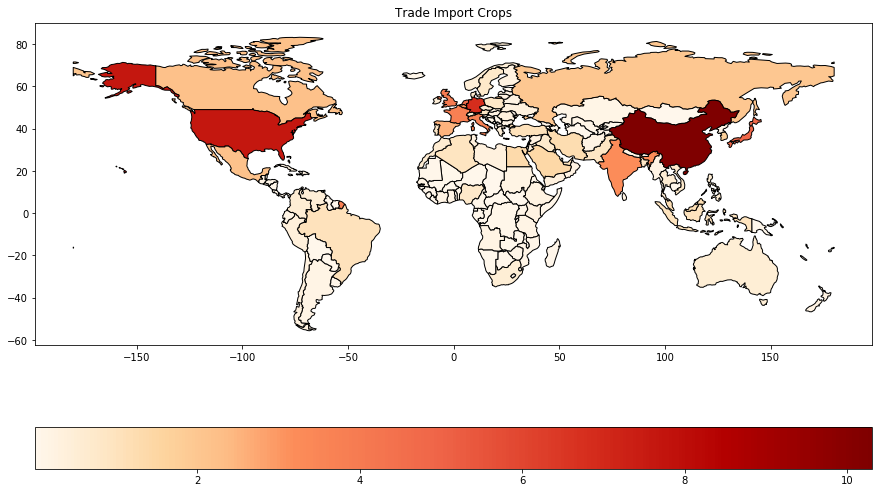

In [123]:
# World map
mapp(trade_import_crops.Recent,'Trade Import Crops')

In [124]:
# Interactive map
interactive_trade_import_crops = interactive_df(trade_import_crops)

In [125]:
df = interactive_trade_import_crops
range_year = (df['Year'].min(),df['Year'].max())
interact(plot_func, year = range_year)

interactive(children=(IntSlider(value=1989, description='year', max=2017, min=1961), Output()), _dom_classes=(…

<function __main__.plot_func(year)>

In [126]:
trade_import_livestock = clean_df(trade_import_livestock,years,to_drop,changes)
interactive_trade_import_livestock = interactive_df(trade_import_livestock)

In [127]:
# Clean dataset
trade_export_crops = clean_df(trade_export_crops,years,to_drop,changes)
trade_export_crops.head()

,Y1961,Y1962,Y1963,Y1964,Y1965,Y1966,Y1967,Y1968,Y1969,Y1970,...,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017,Recent
Area,,,,,,,,,,,,,,,,,,,,,
United States of America,3163874.0,3487312.0,3789497.0,4339904.0,4498790.0,4974040.0,4429132.0,4132554.0,3936864.0,5131329.0,...,56043272.0,65523159.0,75896241.0,76607315.0,73782563.0,78421120.0,68609046.0,72323816.0,71707207.0,13.793369
Spain,385407.0,378119.0,344894.0,458417.0,368812.0,467685.0,549979.0,479163.0,540695.0,758005.0,...,20403972.0,22190664.0,24704875.0,25612523.0,27650694.0,29629443.0,26537701.0,28490800.0,31092569.0,5.459615
Malaysia,98006.0,92663.0,94636.0,94709.0,120619.0,128452.0,124174.0,147605.0,147593.0,241008.0,...,22826671.0,31113211.0,43807649.0,37791847.0,30905097.0,30860981.0,24769800.0,24498746.0,26377864.0,5.411377
Indonesia,84370.0,58161.0,63417.0,84122.0,81761.0,96734.0,79851.0,97016.0,81620.0,126973.0,...,24794962.0,33042847.0,43108586.0,42930247.0,37890481.0,43247378.0,38621851.0,37519893.0,47166010.0,5.369886
Netherlands,312474.0,383278.0,390459.0,401217.0,478715.0,456954.0,507891.0,588668.0,718321.0,848104.0,...,23661026.0,24272083.0,28437595.0,28127912.0,29962496.0,25874797.0,23492802.0,26094908.0,32440671.0,5.150867


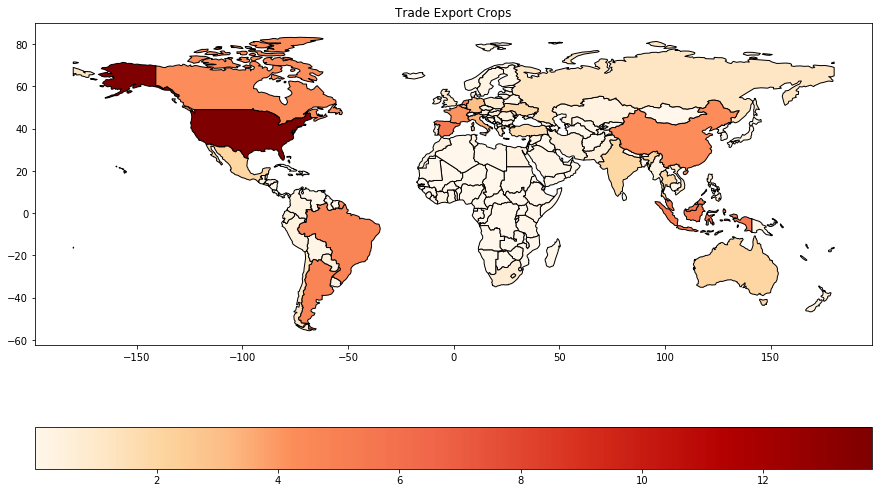

In [128]:
# World map
mapp(trade_export_crops.Recent,'Trade Export Crops')

In [129]:
# Interactive map
interactive_trade_export_crops = interactive_df(trade_export_crops)

In [130]:
df = interactive_trade_export_crops
range_year = (df['Year'].min(),df['Year'].max())
interact(plot_func, year = range_year)

interactive(children=(IntSlider(value=1989, description='year', max=2017, min=1961), Output()), _dom_classes=(…

<function __main__.plot_func(year)>

In [131]:
trade_export_livestock = clean_df(trade_export_livestock,years,to_drop,changes)
interactive_trade_export_livestock = interactive_df(trade_export_livestock)

In [132]:
trade_import_crops.to_pickle("pickle/trade_import_crops.pkl")
trade_export_crops.to_pickle("pickle/trade_export_crops.pkl")
trade_import_livestock.to_pickle("pickle/trade_import_livestock.pkl")
trade_export_livestock.to_pickle("pickle/trade_export_livestock.pkl")

## Trade Matrix

In [288]:
# Load dataset
tradem = pd.read_csv('datasets/'+TRADE_MATRIX, encoding = "ISO-8859-1")
tradem.head()

,Reporter Country Code,Reporter Countries,Partner Country Code,Partner Countries,Item Code,Item,Element Code,Element,Unit,Y1986,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
0,2,Afghanistan,4,Algeria,230,"Cashew nuts, shelled",5910,Export Quantity,tonnes,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN
1,2,Afghanistan,4,Algeria,230,"Cashew nuts, shelled",5922,Export Value,1000 US$,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.0,NaN
2,2,Afghanistan,4,Algeria,1293,Crude materials,5922,Export Value,1000 US$,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,5.0
3,2,Afghanistan,4,Algeria,561,Raisins,5910,Export Quantity,tonnes,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,NaN,NaN,NaN
4,2,Afghanistan,4,Algeria,561,Raisins,5922,Export Value,1000 US$,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,27.0,NaN,NaN,NaN


In [289]:
tradem_import = tradem[tradem.Element=='Import Value']
tradem_import.head()

,Reporter Country Code,Reporter Countries,Partner Country Code,Partner Countries,Item Code,Item,Element Code,Element,Unit,Y1986,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
10,2,Afghanistan,9,Argentina,1232,Food prep nes,5622,Import Value,1000 US$,NaN,...,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN
12,2,Afghanistan,9,Argentina,56,Maize,5622,Import Value,1000 US$,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68.0
14,2,Afghanistan,9,Argentina,1058,"Meat, chicken",5622,Import Value,1000 US$,NaN,...,NaN,NaN,NaN,281.0,NaN,NaN,1163.0,159.0,1653.0,1761.0
16,2,Afghanistan,9,Argentina,897,"Milk, whole dried",5622,Import Value,1000 US$,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,191.0,NaN
18,2,Afghanistan,9,Argentina,164,Sugar refined,5622,Import Value,1000 US$,NaN,...,NaN,NaN,NaN,130.0,NaN,NaN,NaN,NaN,NaN,NaN


In [290]:
tradem_export = tradem[tradem.Element=='Export Value']
tradem_export.head()

,Reporter Country Code,Reporter Countries,Partner Country Code,Partner Countries,Item Code,Item,Element Code,Element,Unit,Y1986,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
1,2,Afghanistan,4,Algeria,230,"Cashew nuts, shelled",5922,Export Value,1000 US$,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.0,NaN
2,2,Afghanistan,4,Algeria,1293,Crude materials,5922,Export Value,1000 US$,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,5.0
4,2,Afghanistan,4,Algeria,561,Raisins,5922,Export Value,1000 US$,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,27.0,NaN,NaN,NaN
6,2,Afghanistan,4,Algeria,723,Spices nes,5922,Export Value,1000 US$,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
8,2,Afghanistan,7,Angola,1232,Food prep nes,5922,Export Value,1000 US$,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN


In [291]:
# define time window and columns to drop
years = ['Y'+str(2000+x) for x in range(0,18)]
to_drop = ['Reporter Country Code','Partner Country Code','Item Code','Element Code']

In [292]:
def cleanm_df(df, to_drop, changes):
    df = df.set_index('Partner Countries').rename(columns={'Reporter Countries':'Area'})
    df = df.replace(changes).rename(columns={'Area':'Reporter'})
    df = df.reset_index().set_index('Reporter').rename(columns={'Partner Countries':'Area'})
    df = df.replace(changes).rename(columns={'Area':'Partner'})
    df = df.groupby(['Reporter','Partner']).sum().reset_index()
    df = df.drop(to_drop, axis=1)
    df = df.loc[df.Reporter.map(lambda x: x in countries),:]
    df = df.loc[df.Partner.map(lambda x: x in countries),:]
    df = df.set_index(['Reporter','Partner'])
    return df[years]

In [293]:
tradem_import = cleanm_df(tradem_import,to_drop,changes)
tradem_export = cleanm_df(tradem_export,to_drop,changes)

We decide to take, for each pair, the average trade value in recent years. Morover, to a better understanding of data, we rename index columns as `From` and `To`: these names better describe the actual goods flow.

In [294]:
# take average
tradem_import = tradem_import.mean(axis=1)
tradem_export = tradem_export.mean(axis=1)

In [295]:
# rename index columns
tradem_import = tradem_import.reset_index().rename(columns={'Reporter':'To','Partner':'From',0:'Value'}).set_index(['From','To'])
tradem_export = tradem_export.reset_index().rename(columns={'Reporter':'From','Partner':'To',0:'Value'}).set_index(['From','To'])

In [296]:
# build a unique dataset
trade_matrix = tradem_import.join(tradem_export,lsuffix='I',rsuffix='E')

In [297]:
# check length
len(trade_matrix)

19798

Let's try to reduce the number of pairs, eliminating those which involve little trading value:

In [298]:
# rank by average trade value in recent years
trade_matrix.mean(axis=1).sort_values(ascending=False).head()

From                      To                      
Canada                    United States of America    1.674693e+07
Netherlands               Germany                     1.655842e+07
United States of America  Canada                      1.540618e+07
                          Mexico                      1.370132e+07
Mexico                    United States of America    1.339552e+07
dtype: float64

We decide that a reasonable choice could be to take into account only trades which involve at least 10M $ on average in recent years

In [299]:
trade_matrix = trade_matrix[trade_matrix.mean(axis=1)>10000]

In [300]:
# check length
len(trade_matrix)

3670

We now check for the consistency into the dataset: indeed, reported export from e.g. Italy to France should be roughly equal to reported import to France from Italy.

In [301]:
ratio = trade_matrix.ValueI/trade_matrix.ValueE
len(ratio[ratio>1.5])+len(ratio[ratio<0.5])

821

Some relevant inconsistency is present (about 20% of the pairs do not fit in the wide 50% tolerance range), so we decide to build a unique matrix by taking the mean of the two values provided.

In [302]:
trade_matrix = pd.DataFrame(trade_matrix.mean(axis=1)).rename(columns={0:'Value'})
trade_matrix.head()

,,Value
From,To,
Azerbaijan,Afghanistan,12254.944444
Germany,Afghanistan,11632.416667
India,Afghanistan,31439.083333
Indonesia,Afghanistan,11131.888889
Iran,Afghanistan,118462.972222


In [303]:
# save pickle file
trade_matrix.to_pickle("pickle/trade_matrix.pkl")

# Land Use

In [221]:
# Load dataset
land_use = pd.read_csv('datasets/'+LAND, encoding='latin-1')
land_use.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Y1961,Y1962,Y1963,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
0,2,Afghanistan,6600,Country area,5110,Area,1000 ha,65286.0,65286.0,65286.0,...,65286.0,65286.0,65286.0,65286.0,65286.0,65286.0,65286.0,65286.0,65286.0,65286.0
1,2,Afghanistan,6601,Land area,5110,Area,1000 ha,65286.0,65286.0,65286.0,...,65286.0,65286.0,65286.0,65286.0,65286.0,65286.0,65286.0,65286.0,65286.0,65286.0
2,2,Afghanistan,6602,Agriculture,5110,Area,1000 ha,37700.0,37760.0,37810.0,...,37910.0,37910.0,37911.0,37910.0,37910.0,37910.0,37910.0,37910.0,37910.0,37910.0
3,2,Afghanistan,6610,Agricultural land,5110,Area,1000 ha,37700.0,37760.0,37810.0,...,37910.0,37910.0,37911.0,37910.0,37910.0,37910.0,37910.0,37910.0,37910.0,37910.0
4,2,Afghanistan,6620,Cropland,5110,Area,1000 ha,7700.0,7760.0,7810.0,...,7910.0,7910.0,7911.0,7910.0,7910.0,7910.0,7910.0,7910.0,7910.0,7910.0


In [222]:
land_use['Element'].value_counts()

Area                              5558
Carbon stock in living biomass     271
Name: Element, dtype: int64

We consider only the `Area` element of the dataset.

In [223]:
land_use = land_use[land_use.Element=='Area']

In [224]:
# Check unit
land_use['Unit'].value_counts()

1000 ha    5558
Name: Unit, dtype: int64

In [225]:
# Have a look at which Items do we have in the dataset
items = land_use[['Area','Item Code','Item']].groupby(['Item Code','Item']).count()
items[items.Area > 50].sort_values('Item Code').head(10)

,,Area
Item Code,Item,
6600,Country area,272
6601,Land area,272
6602,Agriculture,270
6610,Agricultural land,270
6611,Agriculture area actually irrigated,113
6620,Cropland,267
6621,Arable land,263
6630,Land under temporary crops,99
6633,Land under temp. meadows and pastures,56


In [226]:
item_code_list = set([6600, 6601, 6680, 6610, 6620, 6630, 6650, 6621, 6633, 6655, 6646, 6714, 6716, 6717])

In [227]:
changes_item = {'Item' : {'Land under permanent crops' : 'Crops' ,
                    'Land under temporary crops' : 'Crops',
                    'Land under perm. meadows and pastures' : 'Meadows',
                    'Land under temp. meadows and pastures' : 'Meadows',
                    'Other naturally regenerated forest' : 'Other forest'
                    }}

In [228]:
land_use = land_use.replace(changes_item)

In [229]:
to_drop = ['Area Code','Item Code','Element Code']
land_use = clean_df_items(land_use,item_code_list,to_drop,changes)
land_use

,Item,Y1961,Y1962,Y1963,Y1964,Y1965,Y1966,Y1967,Y1968,Y1969,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
Area,,,,,,,,,,,,,,,,,,,,,
Afghanistan,Agricultural land,37700.0,37760.0,37810.0,37873.0,37875.0,37913.0,37979.0,37980.0,37996.0,...,37910.0,37910.0,37911.0,37910.0,37910.0,37910.0,37910.0,37910.0,37910.0,37910.0
Afghanistan,Arable land,7650.0,7700.0,7750.0,7800.0,7800.0,7835.0,7844.0,7844.0,7860.0,...,7794.0,7793.0,7793.0,7791.0,7790.0,7785.0,7771.0,7765.0,7729.0,7699.0
Afghanistan,Country area,65286.0,65286.0,65286.0,65286.0,65286.0,65286.0,65286.0,65286.0,65286.0,...,65286.0,65286.0,65286.0,65286.0,65286.0,65286.0,65286.0,65286.0,65286.0,65286.0
Afghanistan,Cropland,7700.0,7760.0,7810.0,7873.0,7875.0,7913.0,7979.0,7980.0,7996.0,...,7910.0,7910.0,7911.0,7910.0,7910.0,7910.0,7910.0,7910.0,7910.0,7910.0
Afghanistan,Crops,50.0,60.0,60.0,73.0,75.0,78.0,135.0,136.0,136.0,...,3340.0,3586.0,3599.0,3200.0,3574.0,3616.0,3624.0,3500.0,3600.0,3083.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
eSwatini,Land area,1720.0,1720.0,1720.0,1720.0,1720.0,1720.0,1720.0,1720.0,1720.0,...,1720.0,1720.0,1720.0,1720.0,1720.0,1720.0,1720.0,1720.0,1720.0,1720.0
eSwatini,Meadows,1342.0,1342.0,1342.0,1342.0,1342.0,1342.0,1342.0,1342.0,1342.0,...,1032.0,1032.0,1032.0,1032.0,1032.0,1032.0,1032.0,1032.0,1032.0,1032.0
eSwatini,Other forest,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,412.2,417.6,423.0,428.6,434.2,439.8,445.4,451.0,451.0,451.0


We now build a different dataset, taking the average on recent years.

In [230]:
# take mean only on recent years
years = ['Y'+str(2000+x) for x in range(0,18)]
land_use_pivot = land_use.reset_index().set_index(['Area','Item'])[years].mean(axis = 1)

In [231]:
land_use_pivot = land_use_pivot.unstack(level='Item')
land_use_pivot.head()

Item,Agricultural land,Arable land,Country area,Cropland,Crops,Forest land,Inland waters,Land area,Meadows,Other forest,Planted Forest,Primary Forest
Area,,,,,,,,,,,,
Afghanistan,37883.944444,7763.055556,65286.0,7883.944444,3181.111111,1350.000000,NaN,65286.0,30000.000000,1350.000000,0.000000,0.0
Albania,1158.592833,597.283333,2875.0,695.611111,211.916667,775.494444,118.033333,2740.0,577.031722,596.238889,94.455556,84.8
Algeria,41030.173611,7501.883728,238174.0,8362.890339,4774.228183,1765.944444,NaN,238174.0,32667.291100,1312.888889,453.055556,0.0
Angola,58242.777778,3950.000000,124670.0,4242.777778,292.777778,58688.000000,NaN,124670.0,54000.000000,58559.000000,129.000000,0.0
Argentina,141725.388889,34969.944444,278040.0,35969.944444,26355.333333,29169.444444,4371.000000,273669.0,109622.500000,26262.666667,1168.777778,1738.0


In [232]:
land_use_general = land_use_pivot[['Country area','Land area']]
land_use_general['Cropland'] = land_use_pivot['Cropland']/land_use_pivot['Land area']*100
land_use_general['Meadows'] = land_use_pivot['Meadows']/land_use_pivot['Land area']*100
land_use_general['Forestry'] = land_use_pivot['Forest land']/land_use_pivot['Land area']*100

C:\Users\Claudio\Anaconda3\envs\ada\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Claudio\Anaconda3\envs\ada\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Claudio\Anaconda3\envs\ada\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

In [233]:
land_use_general.head(10)

Item,Country area,Land area,Cropland,Meadows,Forestry
Area,,,,,
Afghanistan,65286.0,65286.000000,12.076011,45.951659,2.067825
Albania,2875.0,2740.000000,25.387267,21.059552,28.302717
Algeria,238174.0,238174.000000,3.511252,13.715725,0.741451
Angola,124670.0,124670.000000,3.403207,43.314350,47.074677
Argentina,278040.0,273669.000000,13.143595,40.056601,10.658659
Armenia,2974.0,2847.000000,17.618156,39.185888,11.657495
Australia,774122.0,768338.000000,3.583001,48.134664,16.374000
Austria,8387.9,8256.127778,17.370256,18.338820,46.708741
Azerbaijan,8660.0,8264.527778,25.634590,31.967075,11.925061


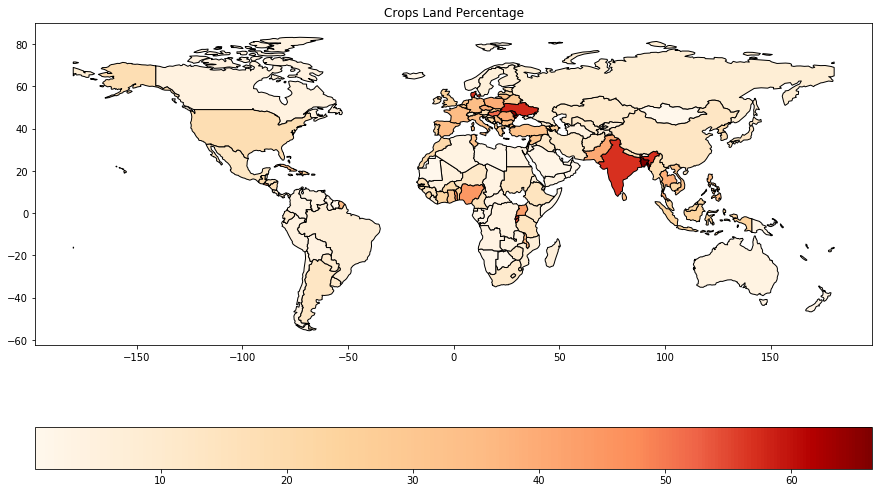

In [234]:
mapp(land_use_general.Cropland,'Crops Land Percentage')

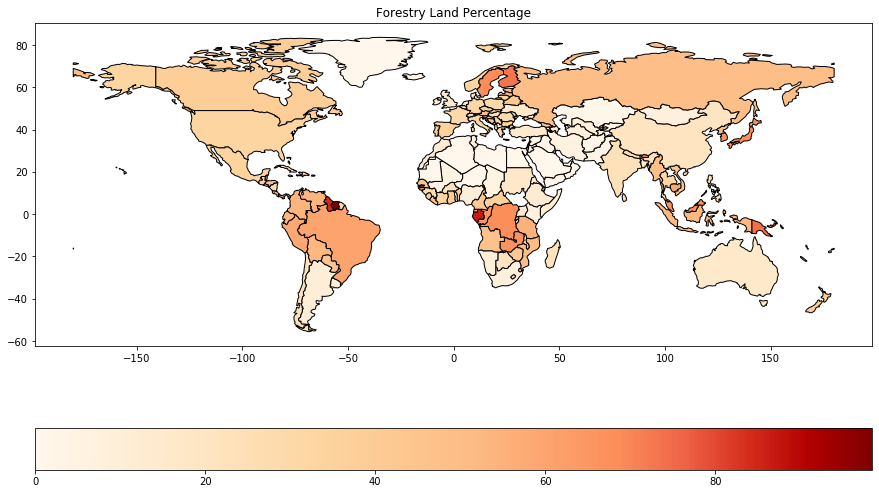

In [235]:
mapp(land_use_general.Forestry,'Forestry Land Percentage')

In [236]:
land_use.to_pickle("pickle/land_use.pkl")
land_use_general.to_pickle("pickle/land_use_general.pkl")

## Soil Quality

In [237]:
soil = pd.read_csv('datasets/'+SOIL, encoding='latin-1')
soil.head()

,CountryCode,Country,ItemCode,Item,ElementGroup,ElementCode,Element,Year,Unit,Value,Flag
0,2,Afghanistan,6709,Soil,7219,7219,Average soil erosion expressed in GLASOD erosi...,1991,degrees,0.22,NaN
1,2,Afghanistan,6709,Soil,7220,7220,Average land degradation in GLASOD erosion degree,1991,degrees,2.64,NaN
2,2,Afghanistan,6709,Soil,7221,7221,Average carbon content in the topsoil as a % i...,2008,%,0.92,NaN
3,5100,Africa + (Total),6709,Soil,7219,7219,Average soil erosion expressed in GLASOD erosi...,1991,degrees,0.89,A
4,5100,Africa + (Total),6709,Soil,7220,7220,Average land degradation in GLASOD erosion degree,1991,degrees,2.10,A


In [238]:
soil.Element.value_counts()

Average carbon content in the topsoil as a % in weight     235
Average land degradation in GLASOD erosion degree          185
Average soil erosion expressed in GLASOD erosion degree    175
Name: Element, dtype: int64

In [239]:
soil = soil.rename(columns={'Country':'Area'})

In [240]:
soil_carbon = soil[soil.ElementCode==7221]
soil_carbon = soil_carbon.drop(columns=['CountryCode','ItemCode','Item','ElementGroup','ElementCode','Element','Unit','Flag'])
soil_carbon = soil_carbon.replace(changes)
soil_carbon = soil_carbon.loc[soil_carbon.Area.map(lambda x: x in countries),:]
soil_carbon = soil_carbon.set_index(['Area'])
soil_carbon.head()

,Year,Value
Area,,
Afghanistan,2008,0.92
Albania,2008,1.24
Algeria,2008,0.81
Angola,2008,0.65
Argentina,2008,1.48


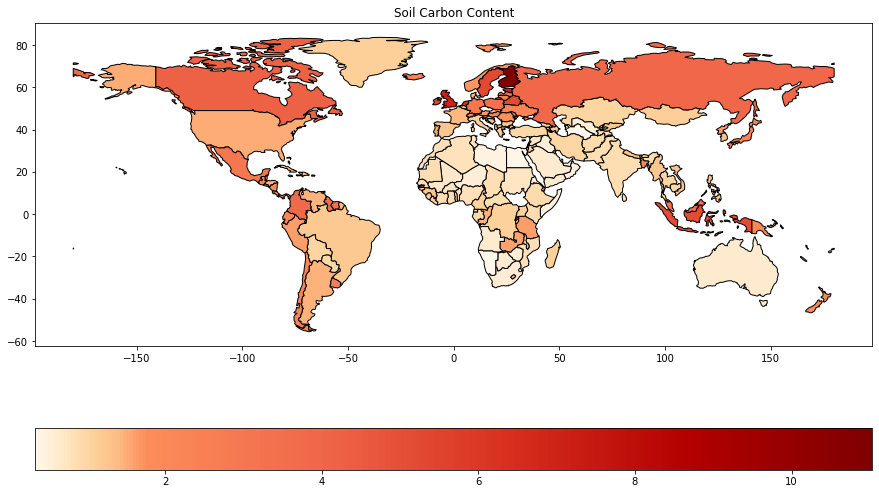

In [241]:
mapp(soil_carbon.Value,'Soil Carbon Content',quant=0.75)

In [242]:
soil_deg = soil[soil.ElementCode==7220]
soil_deg = soil_deg.drop(columns=['CountryCode','ItemCode','Item','ElementGroup','ElementCode','Element','Unit','Flag'])
soil_deg = soil_deg.replace(changes)
soil_deg = soil_deg.loc[soil_deg.Area.map(lambda x: x in countries),:]
soil_deg = soil_deg.set_index(['Area'])
soil_deg.head()

,Year,Value
Area,,
Afghanistan,1991,2.64
Albania,1991,3.65
Algeria,1991,0.64
Angola,1991,1.21
Argentina,1991,2.60


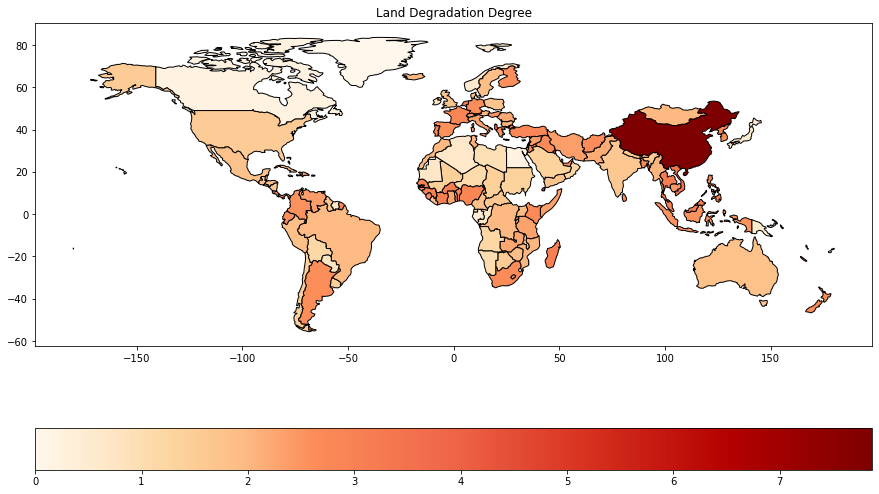

In [243]:
mapp(soil_deg.Value,'Land Degradation Degree',quant=0.75)

In [244]:
soil_ers = soil[soil.ElementCode==7220]
soil_ers = soil_ers.drop(columns=['CountryCode','ItemCode','Item','ElementGroup','ElementCode','Element','Unit','Flag'])
soil_ers = soil_ers.replace(changes)
soil_ers = soil_ers.loc[soil_ers.Area.map(lambda x: x in countries),:]
soil_ers = soil_ers.set_index(['Area'])
soil_ers.head()

,Year,Value
Area,,
Afghanistan,1991,2.64
Albania,1991,3.65
Algeria,1991,0.64
Angola,1991,1.21
Argentina,1991,2.60


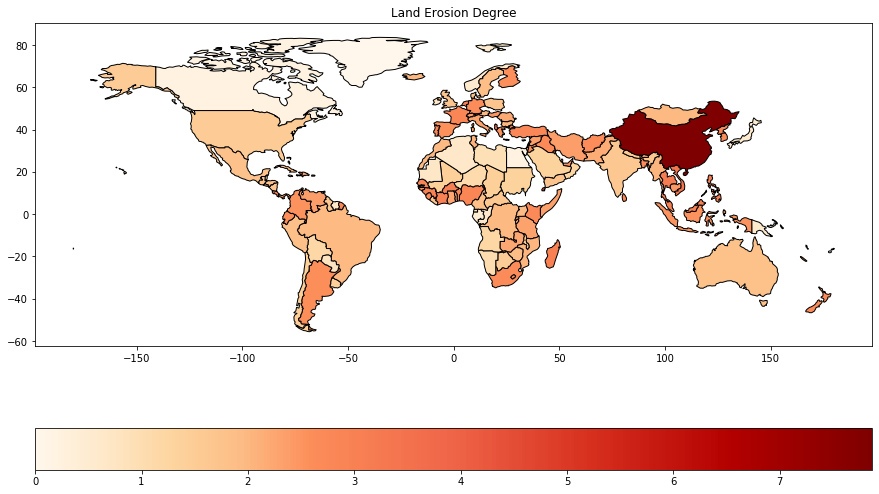

In [245]:
mapp(soil_ers.Value,'Land Erosion Degree',quant=0.75)

In [246]:
soil_carbon.to_pickle("pickle/soil_carbon.pkl")
soil_deg.to_pickle("pickle/soil_deg.pkl")
soil_ers.to_pickle("pickle/soil_ers.pkl")

## Water

In [247]:
water = pd.read_csv('datasets/'+WATER, encoding='latin-1')
water.head()

,CountryCode,Country,ItemCode,Item,ElementGroup,ElementCode,Element,Year,Unit,Value,Flag
0,2,Afghanistan,6720,Water withdrawal for agricultural use,7222,7222,% of total water withdrawal,1987,%,99.00,Fc
1,3,Albania,6720,Water withdrawal for agricultural use,7222,7222,% of total water withdrawal,1990,%,83.33,Fc
2,3,Albania,6720,Water withdrawal for agricultural use,7222,7222,% of total water withdrawal,2000,%,57.61,Fc
3,3,Albania,6720,Water withdrawal for agricultural use,7222,7222,% of total water withdrawal,2006,%,39.69,Fc
4,4,Algeria,6720,Water withdrawal for agricultural use,7222,7222,% of total water withdrawal,1980,%,74.00,Fc


In [248]:
water['Element'].value_counts()

% of total water withdrawal    428
Name: Element, dtype: int64

In [249]:
water = water.drop(columns=['CountryCode','Unit','Element','ElementCode','ElementGroup','Flag','Item','ItemCode'])
water = water.rename(columns={'Country':'Area'})
water.head()

,Area,Year,Value
0,Afghanistan,1987,99.00
1,Albania,1990,83.33
2,Albania,2000,57.61
3,Albania,2006,39.69
4,Algeria,1980,74.00


In [250]:
water = water.replace(changes)
water = water.loc[water.Area.map(lambda x: x in countries),:]
water = water.groupby(['Area']).mean().drop(['Year'],axis=1)
water = water[water.Value>0.1]
water.head()

,Value
Area,
Afghanistan,99.000000
Albania,60.210000
Algeria,65.063333
Angola,43.673333
Argentina,70.685000


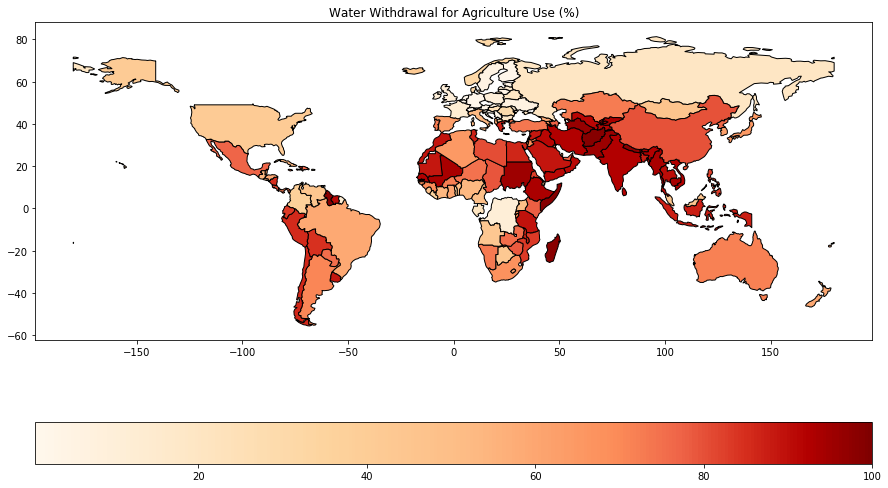

In [251]:
mapp(water.Value,'Water Withdrawal for Agriculture Use (%)',quant=0.5)

In [252]:
water.to_pickle("pickle/water.pkl")

## Energy

In [253]:
energy = pd.read_csv('datasets/'+ENERGY, encoding='latin-1')
energy.head()

,Country Code,Country,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
0,351,China,6801,Gas-Diesel oil,72184,Consumption in Agriculture,1986,1986,Terajoule,288659.0,Fc
1,351,China,6801,Gas-Diesel oil,72184,Consumption in Agriculture,1987,1987,Terajoule,313771.0,Fc
2,351,China,6801,Gas-Diesel oil,72184,Consumption in Agriculture,1988,1988,Terajoule,329896.0,Fc
3,351,China,6801,Gas-Diesel oil,72184,Consumption in Agriculture,1989,1989,Terajoule,355094.0,Fc
4,351,China,6801,Gas-Diesel oil,72184,Consumption in Agriculture,1990,1990,Terajoule,379045.0,Fc


In [254]:
energy['Element'].value_counts()

Consumption in Agriculture             64676
Emissions (CO2eq) from CH4 (Energy)    59489
Emissions (N2O) (Energy)               59489
Emissions (CH4) (Energy)               59489
Emissions (CO2eq) (Energy)             59489
Emissions (CO2eq) from N2O (Energy)    59489
Emissions (CO2) (Energy)               59317
Implied emission factor for N2O        27151
Implied emission factor for CH4        27151
Implied emission factor for CO2        27003
Name: Element, dtype: int64

In [255]:
energy = energy[energy.Element=='Consumption in Agriculture']

In [256]:
energy['Item'].value_counts()

Electricity                                           10374
Transport fuel used in agriculture (excl. fishery)     7370
Energy used in fishery                                 6857
Fuel oil used in fisheries                             6786
Gas-diesel oils used in fisheries                      6778
Total Energy                                           6151
Gas-Diesel oil                                         4756
Energy for power irrigation                            4054
Fuel oil                                               3064
Motor Gasoline                                         2694
Liquefied petroleum gas (LPG)                          2486
Natural gas (including LNG)                            1909
Coal                                                   1397
Name: Item, dtype: int64

In [257]:
energy = energy.drop(columns=['Country Code','Element','Element Code','Year Code','Flag'])

In [258]:
energy.groupby(['Item','Unit']).count()

Country  \
Item                                               Unit                   
Coal                                               Terajoule       1397   
Electricity                                        Terajoule       5187   
                                                   million kWh     5187   
Energy for power irrigation                        Terajoule       4054   
Energy used in fishery                             Terajoule       6857   
Fuel oil                                           Terajoule       3064   
Fuel oil used in fisheries                         Terajoule       6786   
Gas-Diesel oil                                     Terajoule       4756   
Gas-diesel oils used in fisheries                  Terajoule       6778   
Liquefied petroleum gas (LPG)                      Terajoule       2486   
Motor Gasoline                                     Terajoule       2694   
Natural gas (including LNG)                        Terajoule       1909   
Total Energy                                       Terajoule       6151   
Transport fuel used in agriculture (excl. fishery) Terajoule       7370   

                                                                Item Code  \
Item                                               Unit                     
Coal                                               Terajoule         1397   
Electricity                                        Terajoule         5187   
                                                   million kWh       5187   
Energy for power irrigation                        Terajoule         4054   
Energy used in fishery                             Terajoule         6857   
Fuel oil                                           Terajoule         3064   
Fuel oil used in fisheries                         Terajoule         6786   
Gas-Diesel oil                                     Terajoule         4756   
Gas-diesel oils used in fisheries                  Terajoule         6778   
Liquefied petroleum gas (LPG)                      Terajoule         2486   
Motor Gasoline                                     Terajoule         2694   
Natural gas (including LNG)                        Terajoule         1909   
Total Energy                                       Terajoule         6151   
Transport fuel used in agriculture (excl. fishery) Terajoule         7370   

                                                                Year  Value  
Item                                               Unit                      
Coal                                               Terajoule    1397   1397  
Electricity                                        Terajoule    5187   5187  
                                                   million kWh  5187   5187  
Energy for power irrigation                        Terajoule    4054   4054  
Energy used in fishery                             Terajoule    6857   6857  
Fuel oil                                           Terajoule    3064   3064  
Fuel oil used in fisheries                         Terajoule    6786   6786  
Gas-Diesel oil                                     Terajoule    4756   4756  
Gas-diesel oils used in fisheries                  Terajoule    6778   6778  
Liquefied petroleum gas (LPG)                      Terajoule    2486   2486  
Motor Gasoline                                     Terajoule    2694   2694  
Natural gas (including LNG)                        Terajoule    1909   1909  
Total Energy                                       Terajoule    6151   6151  
Transport fuel used in agriculture (excl. fishery) Terajoule    7370   7370

In [259]:
energy = energy[energy.Unit=='Terajoule']
energy = energy.drop(columns=['Unit'])

In [260]:
energy = energy.replace(changes)
energy = energy.loc[energy.Country.map(lambda x: x in countries),:]
energy.head()

,Country,Item Code,Item,Year,Value
0,China,6801,Gas-Diesel oil,1986,288659.0
1,China,6801,Gas-Diesel oil,1987,313771.0
2,China,6801,Gas-Diesel oil,1988,329896.0
3,China,6801,Gas-Diesel oil,1989,355094.0
4,China,6801,Gas-Diesel oil,1990,379045.0


In [261]:
energy_space = energy[energy.Year >= 2000].drop(columns=['Item Code','Year']).groupby(['Country','Item']).mean()
energy_space = energy_space.unstack(['Item'])
energy_space.head()

Value                                           \
Item         Coal  Electricity Energy for power irrigation   
Country                                                      
Afghanistan   NaN   207.692308                  989.520000   
Albania       NaN   250.892308                    0.180500   
Algeria       NaN  1256.400000                  347.200000   
Angola        NaN          NaN                         NaN   
Argentina     NaN  2673.692308                 2775.315154   

                                                                        \
Item        Energy used in fishery Fuel oil Fuel oil used in fisheries   
Country                                                                  
Afghanistan                    NaN      NaN                        NaN   
Albania                 845.273769    44.44                        0.0   
Algeria                   0.000000      NaN                        0.0   
Angola                    0.000000      NaN                        0.0   
Argentina               770.707692  1252.40                        0.0   

                                                              \
Item        Gas-Diesel oil Gas-diesel oils used in fisheries   
Country                                                        
Afghanistan            NaN                               NaN   
Albania        2798.307692                        811.089154   
Algeria         673.666667                          0.000000   
Angola          191.846154                          0.000000   
Argentina    129850.076923                          0.000000   

                                                          \
Item        Liquefied petroleum gas (LPG) Motor Gasoline   
Country                                                    
Afghanistan                           NaN            NaN   
Albania                               NaN            NaN   
Algeria                        197.083333            NaN   
Angola                                NaN            NaN   
Argentina                     3649.983333     118.133333   

                                                        \
Item        Natural gas (including LNG)   Total Energy   
Country                                                  
Afghanistan                         NaN     207.692308   
Albania                             NaN    3083.384615   
Algeria                           732.0    2118.775000   
Angola                              NaN     191.846154   
Argentina                           NaN  135006.346154   

                                                                
Item        Transport fuel used in agriculture (excl. fishery)  
Country                                                         
Afghanistan                                                NaN  
Albania                                            1987.218538  
Algeria                                             310.923077  
Angola                                              191.846154  
Argentina                                        129877.338462

C:\Users\Claudio\Anaconda3\envs\ada\lib\site-packages\pandas\core\reshape\merge.py:617: UserWarning:

merging between different levels can give an unintended result (1 levels on the left, 2 on the right)



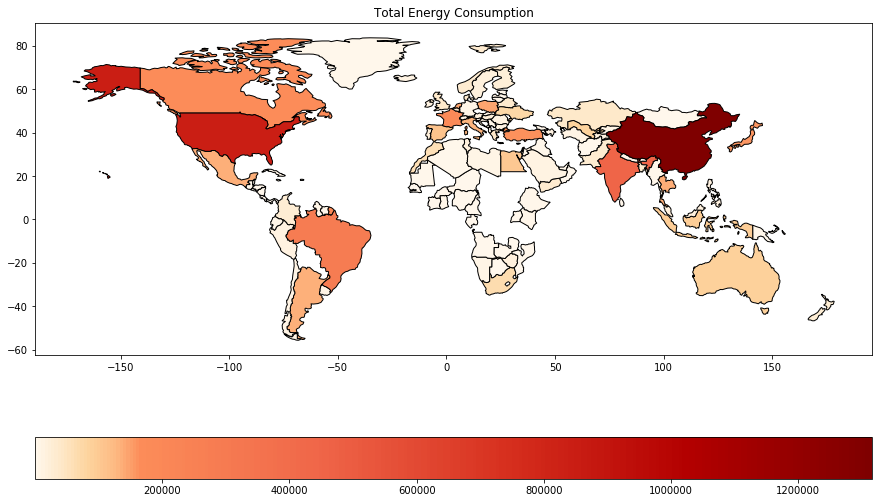

In [262]:
mapp(energy_space[energy_space.columns[11]],'Total Energy Consumption')

In [263]:
energy_time = energy.drop(columns=['Item Code']).groupby(['Item','Year']).sum()
energy_time = energy_time.unstack(['Item'])
energy_time

Value                                                                 \
Item      Coal Electricity Energy for power irrigation Energy used in fishery   
Year                                                                            
1970       NaN    102160.8                   4579.5680             110817.200   
1971       0.0    109260.0                   4579.5680             116944.250   
1972       0.0    123688.8                   4579.5680             104309.407   
1973       0.0    139557.6                   4579.5680             121802.199   
1974       0.0    157993.2                   4579.5680             121376.409   
1975       0.0    166993.2                   4696.2012             115281.856   
1976       0.0    187045.2                   4696.2012             111081.778   
1977       0.0    202928.4                   4696.2012             116213.958   
1978       0.0    239842.8                   4696.2012             124956.413   
1979   23632.8    373147.2                   4696.2012             133260.890   
1980   49587.6    392803.2                   5121.9118             139603.043   
1981   44866.2    437223.6                   6297.2402             117755.596   
1982   44272.8    478900.8                  10983.0731             117930.032   
1983   32791.8    498168.0                  10545.6011             114945.733   
1984   44892.0    533026.8                  10545.6011             111544.607   
1985   60836.4    572151.6                  12633.0976             101303.778   
1986  620361.0    515106.0                  14842.7705              96462.172   
1987  615742.8    553928.4                  14843.4649              98785.752   
1988  656377.8    591541.2                  15380.6614             104100.502   
1989  603152.4    587656.8                  15524.7494             101572.935   
1990  594251.4    657687.6                  35238.5987             159970.010   
1991  646754.4    718462.8                  44815.8988             363054.593   
1992  558441.0    985478.4                  69606.3382             384593.194   
1993  537826.8    975333.6                  78515.9511             362108.288   
1994  585582.6   1042711.2                  81982.8039             375133.172   
1995  621393.0   1074229.2                  84029.1972             368185.375   
1996  638550.0   1082224.8                  90720.6092             392320.716   
1997  618735.6   1104789.6                  97346.8257             362934.793   
1998  613111.2   1112400.0                 106465.6448             338766.681   
1999  556841.4   1103130.0                 107024.6542             334943.412   
2000  488058.6   1077649.2                 128895.2830             347887.911   
2001  469740.6   1103198.4                 140636.3805             368122.466   
2002  480034.8   1274943.6                 145057.2190             372576.321   
2003  343785.0   1244617.2                 132731.1937             442632.421   
2004  434420.4   1297152.0                 137659.1682             450332.266   
2005  455060.4   1338613.2                 234947.7183             354344.816   
2006  448533.0   1389877.2                 279392.9118             338508.792   
2007  453538.2   1404651.6                 292976.4417             342903.005   
2008  453486.6   1455778.8                 292976.4417             321129.103   
2009  479699.4   1515067.2                 293047.8729             288926.053   
2010  521366.4   1550862.0                 294953.3083             266848.200   
2011  537388.2   1580454.0                 312520.2395             262024.331   
2012  548972.4   1608580.8                 317691.9180             265645.080   

                                                          \
Item  Fuel oil Fuel oil used in fisheries Gas-Diesel oil   
Year                                                       
1970  110817.2                        NaN       826503.0   
1971  110857.6                 15516.1856 

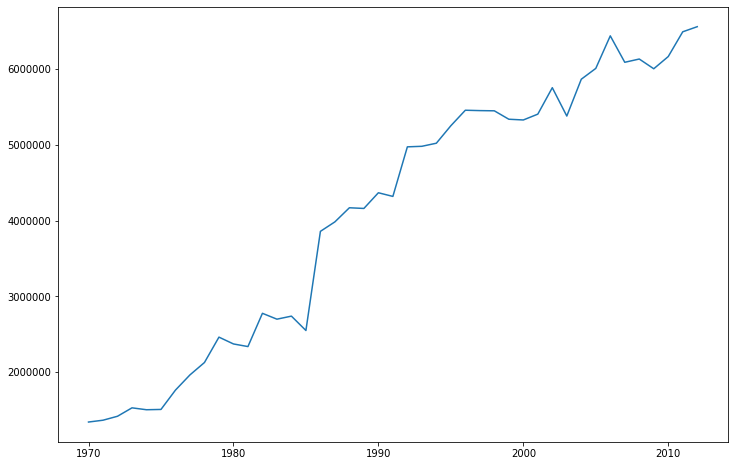

In [264]:
plt.figure(figsize=(12,8))
plt.plot(energy_time[energy_time.columns[11]])

In [265]:
energy.to_pickle("pickle/energy.pkl")
energy_space.to_pickle("pickle/energy_space.pkl")
energy_time.to_pickle("pickle/energy_time.pkl")

## Climate Change

In [266]:
climate_change = pd.read_csv('datasets/'+CLIMATE,encoding = "ISO-8859-1")
climate_change.head()

,Area Code,Area,Months Code,Months,Element Code,Element,Unit,Y1961,Y1962,Y1963,...,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017,Y2018
0,2,Afghanistan,7001,January,7271,Temperature change,°C,0.993,0.137,2.441,...,1.764,3.677,1.096,-0.304,2.136,2.422,2.278,3.621,0.279,2.700
1,2,Afghanistan,7001,January,6078,Standard Deviation,°C,1.888,1.888,1.888,...,1.888,1.888,1.888,1.888,1.888,1.888,1.888,1.888,1.888,1.888
2,2,Afghanistan,7002,February,7271,Temperature change,°C,-1.542,2.421,3.849,...,3.025,0.857,1.112,-2.161,0.348,-1.617,3.687,1.713,-0.377,2.652
3,2,Afghanistan,7002,February,6078,Standard Deviation,°C,2.456,2.456,2.456,...,2.456,2.456,2.456,2.456,2.456,2.456,2.456,2.456,2.456,2.456
4,2,Afghanistan,7003,March,7271,Temperature change,°C,0.536,1.444,0.327,...,2.543,4.204,1.837,0.464,-1.072,0.171,-0.133,1.178,0.100,4.214


In [267]:
climate_change = climate_change[climate_change.Element=='Temperature change']
climate_change = climate_change[climate_change.Months=='Meteorological year']
climate_change.head()

,Area Code,Area,Months Code,Months,Element Code,Element,Unit,Y1961,Y1962,Y1963,...,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017,Y2018
32,2,Afghanistan,7020,Meteorological year,7271,Temperature change,°C,-0.059,-0.154,0.820,...,1.633,1.881,1.787,0.722,1.251,1.299,1.414,1.817,1.716,2.029
66,3,Albania,7020,Meteorological year,7271,Temperature change,°C,0.656,0.318,0.072,...,0.848,0.936,0.701,1.478,1.420,1.157,1.321,1.307,0.990,1.656
100,4,Algeria,7020,Meteorological year,7271,Temperature change,°C,0.378,0.220,0.077,...,0.873,2.151,1.351,1.103,1.181,1.697,1.173,1.862,1.520,1.196
134,5,American Samoa,7020,Meteorological year,7271,Temperature change,°C,-0.085,-0.188,-0.024,...,0.999,NaN,0.582,0.496,0.822,0.819,0.563,1.079,0.988,0.738
168,6,Andorra,7020,Meteorological year,7271,Temperature change,°C,0.691,0.107,-0.719,...,1.443,0.459,1.744,1.357,0.779,1.958,1.547,1.825,1.774,1.822


In [268]:
to_drop = ['Area Code','Months Code','Element Code']
climate_change = clean_df(climate_change,years,to_drop,changes)

In [269]:
climate_change = climate_change.drop('World').drop('Recent',axis=1)
climate_change = climate_change.fillna(0)
climate_change.head()

,Y1961,Y1962,Y1963,Y1964,Y1965,Y1966,Y1967,Y1968,Y1969,Y1970,...,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017,Y2018
Area,,,,,,,,,,,,,,,,,,,,,
Qatar,-0.313,0.000,0.038,-0.547,0.175,0.454,-0.458,-0.483,0.511,0.230,...,1.773,2.631,1.917,1.767,1.811,2.014,2.726,2.164,2.428,2.647
Tunisia,0.184,0.014,-0.254,0.239,-0.236,0.283,-0.033,-0.014,-0.057,-0.164,...,1.274,2.031,1.488,1.859,1.558,1.883,1.548,1.978,1.689,1.463
Kyrgyzstan,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,1.392,1.694,1.770,0.679,1.770,1.105,1.750,2.150,1.460,1.665
Lithuania,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,1.476,0.871,1.007,1.476,1.111,2.306,2.267,1.969,1.619,2.499
Latvia,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,1.532,0.748,1.111,1.405,1.131,2.234,2.263,1.939,1.546,2.351


In [270]:
climate_change.to_pickle("pickle/climate_change.pkl")

In [271]:
interactive_climate_change = climate_change
interactive_climate_change.columns = interactive_climate_change.columns.str.replace('Y', '')
interactive_climate_change = interactive_climate_change.stack()
interactive_climate_change = interactive_climate_change.reset_index()
interactive_climate_change = interactive_climate_change.rename(columns={'level_1': 'Year', 0: 'Total'})
interactive_climate_change['Year'] = interactive_climate_change['Year'].astype(int)

In [273]:
interactive_climate_change.head()

,Area,Year,Total
0,Qatar,1961,-0.313
1,Qatar,1962,0.000
2,Qatar,1963,0.038
3,Qatar,1964,-0.547
4,Qatar,1965,0.175


In [274]:
df = interactive_climate_change
range_year = (df['Year'].min(),df['Year'].max())
interact(plot_func, year = range_year)

interactive(children=(IntSlider(value=1989, description='year', max=2018, min=1961), Output()), _dom_classes=(…

<function __main__.plot_func(year)>

## Final visualization

In [275]:
# define unique dataset
complete = interactive_crops.set_index(['Area','Year'])
complete = complete.rename(columns = {'Total': 'Crops'})
complete

Crops
Area    Year           
China   1961  15.429801
        1962  15.718803
        1963  15.496045
        1964  15.268577
        1965  16.774852
...                 ...
Iceland 2013   0.000280
        2014   0.000302
        2015   0.000321
        2016   0.000384
        2017   0.000358

[9405 rows x 1 columns]

In [276]:
def to_complete(df,complete,name):
    df['Year'] = df['Year'].astype(int)
    df = df.set_index(['Area','Year'])
    df = df.rename(columns = {'Total': name})
    complete = complete.join(df)
    return complete

In [277]:
l = [interactive_live_stock_meat,interactive_value_crops,interactive_value_livestock,interactive_emissions_livestock,\
     interactive_emissions_crops,interactive_fertilizers,interactive_pesticides,interactive_trade_import_crops,\
     interactive_trade_export_crops,interactive_trade_import_livestock,interactive_trade_export_livestock]
l_name = ['Livestock Meat','Production Value Crops','Production Value Livestock','Emissions Livestock','Emissions Crops',\
          'Fertilizers','Pesticides','Trade Import Crops','Trade Export Crops','Trade Import Livestock','Trade Export Livestock']

In [278]:
for i in range(len(l)):
    complete = to_complete(l[i],complete,l_name[i])

In [279]:
complete.head()

Crops  Livestock Meat  Production Value Crops  \
Area  Year                                                      
China 1961  15.429801        2.024232                2.562401   
      1962  15.718803        2.064966                2.795185   
      1963  15.496045        2.123587                3.636961   
      1964  15.268577        2.215943                4.296478   
      1965  16.774852        2.299004                4.624716   

            Production Value Livestock  Emissions Livestock  Emissions Crops  \
Area  Year                                                                     
China 1961                   12.570907             6.164433        19.194828   
      1962                   12.750458             5.958853        19.013760   
      1963                   12.866036             6.152220        19.460080   
      1964                   13.198356             6.539071        20.156483   
      1965                   14.111091             6.744195        20.429136   

            Fertilizers  Pesticides  Trade Import Crops  Trade Export Crops  \
Area  Year                                                                    
China 1961     2.388758         NaN            5.235462            1.793260   
      1962     2.987113         NaN            4.614330            2.460967   
      1963     3.397942         NaN            4.881884            2.854563   
      1964     4.098548         NaN            4.874646            3.117919   
      1965     5.660183         NaN            4.355804            3.621225   

            Trade Import Livestock  Trade Export Livestock  
Area  Year                                                  
China 1961                1.278482                0.693998  
      1962                1.214934                0.732912  
      1963                1.308729                1.230847  
      1964                1.272798                1.701949  
      1965                1.238512                2.731929

In [280]:
complete.to_pickle("pickle/complete.pkl")

In [281]:
complete = complete.reset_index()
complete

,Area,Year,Crops,Livestock Meat,Production Value Crops,Production Value Livestock,Emissions Livestock,Emissions Crops,Fertilizers,Pesticides,Trade Import Crops,Trade Export Crops,Trade Import Livestock,Trade Export Livestock
0,China,1961,15.429801,2.024232,2.562401,12.570907,6.164433,19.194828,2.388758,NaN,5.235462,1.793260,1.278482,0.693998
1,China,1962,15.718803,2.064966,2.795185,12.750458,5.958853,19.013760,2.987113,NaN,4.614330,2.460967,1.214934,0.732912
2,China,1963,15.496045,2.123587,3.636961,12.866036,6.152220,19.460080,3.397942,NaN,4.881884,2.854563,1.308729,1.230847
3,China,1964,15.268577,2.215943,4.296478,13.198356,6.539071,20.156483,4.098548,NaN,4.874646,3.117919,1.272798,1.701949
4,China,1965,16.774852,2.299004,4.624716,14.111091,6.744195,20.429136,5.660183,NaN,4.355804,3.621225,1.238512,2.731929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9400,Iceland,2013,0.000280,0.011347,0.012227,0.000191,0.010602,0.012005,0.011013,0.000060,0.025220,0.000238,0.007757,0.011353
9401,Iceland,2014,0.000302,0.011024,0.012178,0.000213,0.011156,0.012672,0.012849,0.000095,0.025412,0.000171,0.009905,0.016238
9402,Iceland,2015,0.000321,0.011064,0.012551,0.000211,0.011176,0.012925,0.009564,0.000101,0.025471,0.000345,0.010770,0.017866
9403,Iceland,2016,0.000384,0.011637,0.012868,0.000226,0.010932,0.012725,0.011570,0.000090,0.027487,0.000441,0.013029,0.019676


In [282]:
def plot_func(countries,features):
    countries = list(countries)
    features = list(features)
    plot = compare_different_country(complete, country=countries, feature=features, plot=True)
    return

In [283]:
f = list(complete.columns)
f.remove('Area')
f.remove('Year')
c = set(['China', 'United States of America', 'India', 'Brazil', 'Indonesia',
       'Russia', 'Nigeria', 'France', 'Argentina', 'Thailand'])

In [284]:
s_c = SelectMultiple(options=c, description='country', rows=len(c), layout=Layout(width="100%"))
s_f = SelectMultiple(options=f, description='features', rows=len(f), layout=Layout(width="100%"))
interact(plot_func, countries= s_c , features = s_f)

interactive(children=(SelectMultiple(description='country', layout=Layout(width='100%'), options=('Thailand', …

<function __main__.plot_func(countries, features)>

In [285]:
l_df = list(complete.columns)
l_df.remove('Area')
l_df.remove('Year')

In [286]:
def plot_func(df,year):
    result = complete[['Area','Year']+[str(df)]]
    result = result.set_index('Area')
    result = result[result['Year']==year]
    result = result.rename(columns={"Year": "Year"})
    result = result.rename(columns={str(df): "Total"})
    return mapp_interactive(result)

In [287]:
interact(plot_func, df = l_df ,year = range(1961,2014))

interactive(children=(Dropdown(description='df', options=('Crops', 'Livestock Meat', 'Production Value Crops',…

<function __main__.plot_func(df, year)>

# VIDEO LINKS

Since it's not possible to do interactive plots in a notebook on Jupyter, we decided to show our results in the following videos. 

[Time Series](https://streamable.com/lum73)


[Choropleth Maps](https://streamable.com/it97j)